In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [3]:
import keras.utils
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
df = pd.read_csv('Data/16M_7_day_lag_with_price_changes.csv', 
                 usecols=['date', 'compound', 'negative', 'positive', 'daily_count', 'price_direction', 'price_change', 'lagged_close'])

In [5]:
df = df[df['date'] >= '2018-08-28']

In [6]:
df

,date,negative,positive,compound,daily_count,lagged_close,price_change,price_direction
278,2018-08-28,0.007695,0.028635,0.062261,750,7361.660156,265.380371,positive
279,2018-08-29,0.006276,0.028844,0.072007,736,6792.830078,254.330078,negative
280,2018-08-30,0.009227,0.029736,0.064531,746,6529.169922,449.060059,negative
281,2018-08-31,0.008908,0.027812,0.055598,682,6467.069824,570.510254,negative
282,2018-09-01,0.008893,0.025307,0.049348,642,6225.979980,967.270020,negative
...,...,...,...,...,...,...,...,...
726,2019-11-19,0.038151,0.093721,0.165424,43287,7218.371094,987.774414,negative
727,2019-11-20,0.036158,0.099087,0.181522,42112,7531.663574,495.604492,negative
728,2019-11-21,0.042986,0.096216,0.155917,47978,7463.105957,179.644043,negative
729,2019-11-22,0.048450,0.090741,0.129012,51043,7761.243652,464.666016,positive


In [7]:
df['price_change'] = df.apply(lambda row: -1 * row['price_change'] if row['price_direction'] == 'negative' else row['price_change'], axis=1)

In [8]:
df

,date,negative,positive,compound,daily_count,lagged_close,price_change,price_direction
278,2018-08-28,0.007695,0.028635,0.062261,750,7361.660156,265.380371,positive
279,2018-08-29,0.006276,0.028844,0.072007,736,6792.830078,-254.330078,negative
280,2018-08-30,0.009227,0.029736,0.064531,746,6529.169922,-449.060059,negative
281,2018-08-31,0.008908,0.027812,0.055598,682,6467.069824,-570.510254,negative
282,2018-09-01,0.008893,0.025307,0.049348,642,6225.979980,-967.270020,negative
...,...,...,...,...,...,...,...,...
726,2019-11-19,0.038151,0.093721,0.165424,43287,7218.371094,-987.774414,negative
727,2019-11-20,0.036158,0.099087,0.181522,42112,7531.663574,-495.604492,negative
728,2019-11-21,0.042986,0.096216,0.155917,47978,7463.105957,-179.644043,negative
729,2019-11-22,0.048450,0.090741,0.129012,51043,7761.243652,464.666016,positive


In [9]:
min_change = df['price_change'].min()
max_change = df['price_change'].max()

print(f'Min: {min_change}')
print(f'Max: {max_change}') 

Min: -3096.1708984375
Max: 3742.7099609375


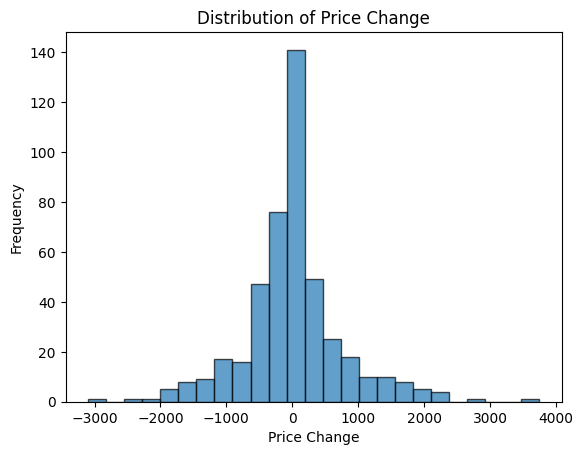

In [10]:
plt.hist(df['price_change'], bins=25, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Price Change')
plt.ylabel('Frequency')
plt.title('Distribution of Price Change')

# Display the plot
plt.show()

In [11]:
len(df[df['price_change'] > 330])

95

In [12]:
len(df[(df['price_change'] < 330) & (df['price_change'] > 0)])

123

In [13]:
len(df[df['price_change'] < 0])

235

In [14]:
len(df[(df['price_change'] > -330) & (df['price_change'] < 0)])

124

In [15]:
len(df[df['price_change'] < -330])

111

In [16]:
# Create bins
bins = [float("-inf"), -330, 0., 330, float("inf")]
labels = [0, 1, 2, 3]

# Put records into bins
df['price_change'] = pd.cut(x=df['price_change'], bins=bins, labels=labels, include_lowest=True)
df

,date,negative,positive,compound,daily_count,lagged_close,price_change,price_direction
278,2018-08-28,0.007695,0.028635,0.062261,750,7361.660156,2,positive
279,2018-08-29,0.006276,0.028844,0.072007,736,6792.830078,1,negative
280,2018-08-30,0.009227,0.029736,0.064531,746,6529.169922,0,negative
281,2018-08-31,0.008908,0.027812,0.055598,682,6467.069824,0,negative
282,2018-09-01,0.008893,0.025307,0.049348,642,6225.979980,0,negative
...,...,...,...,...,...,...,...,...
726,2019-11-19,0.038151,0.093721,0.165424,43287,7218.371094,0,negative
727,2019-11-20,0.036158,0.099087,0.181522,42112,7531.663574,0,negative
728,2019-11-21,0.042986,0.096216,0.155917,47978,7463.105957,1,negative
729,2019-11-22,0.048450,0.090741,0.129012,51043,7761.243652,3,positive


In [17]:
df['price_change'].value_counts()

1    124
2    123
0    111
3     95
Name: price_change, dtype: int64

In [18]:
# Copying df for further manipulations
df_copy = df.copy()

In [19]:
features = ['price_change', 'lagged_close', 'positive', 'negative', 'daily_count']

In [20]:
df_copy = df_copy[features]

In [21]:
# Number of previous records to consider for every example (Window size)
n_lag = 3

# Number of features
n_features = len(features)

# Calculate total_features
total_features = n_lag * n_features

if(total_features == 0):
    total_features = n_features

In [22]:
def create_lagged_features(data, n_lagged_features=1, to_remove=1):
    variables = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    columns, names = list(), list()
    
    for i in range(n_lagged_features, 0, -1):
        columns.append(df.shift(i))
        names += [f'feature{j+1}(t-{i})' for j in range(variables)]

    for i in range(0, to_remove):
        columns.append(df.shift(-i))
        if i == 0:
            names += [f'feature{j+1}(t)' for j in range(variables)]
        else:
            names += [f'feature{j+1}(t+{i})' for j in range(variables)]
            
    prepped_df = pd.concat(columns, axis=1)
    prepped_df.columns = names
    
    # Drop rows with NaN values
    prepped_df.dropna(inplace=True)
        
    return prepped_df

In [23]:
# Create lagged data (previous data window) columns
lagged_data = create_lagged_features(df_copy, n_lag, 1)
lagged_data = lagged_data.reset_index()
lagged_data = lagged_data.drop(['index'], axis=1)

In [24]:
lagged_data

,feature1(t-3),feature2(t-3),feature3(t-3),feature4(t-3),feature5(t-3),feature1(t-2),feature2(t-2),feature3(t-2),feature4(t-2),feature5(t-2),feature1(t-1),feature2(t-1),feature3(t-1),feature4(t-1),feature5(t-1),feature1(t),feature2(t),feature3(t),feature4(t),feature5(t)
0,2,7361.660156,0.028635,0.007695,750.0,1,6792.830078,0.028844,0.006276,736.0,0,6529.169922,0.029736,0.009227,746.0,0,6467.069824,0.027812,0.008908,682
1,1,6792.830078,0.028844,0.006276,736.0,0,6529.169922,0.029736,0.009227,746.0,0,6467.069824,0.027812,0.008908,682.0,0,6225.979980,0.025307,0.008893,642
2,0,6529.169922,0.029736,0.009227,746.0,0,6467.069824,0.027812,0.008908,682.0,0,6225.979980,0.025307,0.008893,642.0,0,6300.859863,0.028598,0.010656,659
3,0,6467.069824,0.027812,0.008908,682.0,0,6225.979980,0.025307,0.008893,642.0,0,6300.859863,0.028598,0.010656,659.0,0,6329.700195,0.024956,0.009593,707
4,0,6225.979980,0.025307,0.008893,642.0,0,6300.859863,0.028598,0.010656,659.0,0,6329.700195,0.024956,0.009593,707.0,0,6321.200195,0.025445,0.006964,719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,0,7397.796875,0.093754,0.039901,33199.0,0,7047.916992,0.092225,0.039410,33029.0,0,7146.133789,0.090824,0.037751,41172.0,0,7218.371094,0.093721,0.038151,43287
446,0,7047.916992,0.092225,0.039410,33029.0,0,7146.133789,0.090824,0.037751,41172.0,0,7218.371094,0.093721,0.038151,43287.0,0,7531.663574,0.099087,0.036158,42112
447,0,7146.133789,0.090824,0.037751,41172.0,0,7218.371094,0.093721,0.038151,43287.0,0,7531.663574,0.099087,0.036158,42112.0,1,7463.105957,0.096216,0.042986,47978
448,0,7218.371094,0.093721,0.038151,43287.0,0,7531.663574,0.099087,0.036158,42112.0,1,7463.105957,0.096216,0.042986,47978.0,3,7761.243652,0.090741,0.048450,51043


In [25]:
X = lagged_data.iloc[:, :total_features].values
y = lagged_data['feature1(t)'].values

In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=4)

In [27]:
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (382, 15) (382,)
Testing set shape: (68, 15) (68,)


In [28]:
# Normalise features
xscaler = MinMaxScaler(feature_range=(0, 1))
X_train = xscaler.fit_transform(X_train)
X_test = xscaler.transform(X_test)

In [29]:
# Reshape to match LSTM input [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_lag, n_features))
X_test = X_test.reshape((X_test.shape[0], n_lag, n_features))

In [30]:
X_train.shape

(382, 3, 5)

In [31]:
# Set two class values (1-hot method)
y_train = keras.utils.to_categorical(y_train, 4)

### LSTM Model

In [32]:
EPOCHS = 10000

In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [34]:
y_eval = keras.utils.to_categorical(y_test, 4)

In [35]:
# Optimize hyperparameters
import optuna

In [36]:
np.random.seed(1) 
tf.random.set_seed(1)

In [37]:
def objective(trial):
    activation_funcs = ['relu', 'tanh', 'selu', 'swish', 'linear']

    # Hyperparameters that will be changed
    activation_func_1 = trial.suggest_categorical('activation_func_1', activation_funcs)
    activation_func_2 = trial.suggest_categorical('activation_func_2', activation_funcs)
    activation_func_3 = trial.suggest_categorical('activation_func_3', activation_funcs)
    batch_size = trial.suggest_categorical('batch_size', [32, 50, 64, 80])
    dropout_1 = trial.suggest_categorical('dropout_1', [0.25, 0.5])
    dropout_2 = trial.suggest_categorical('dropout_2', [0.25, 0.5])
    dropout_3 = trial.suggest_categorical('dropout_3', [0.25, 0.5])
    neurons = trial.suggest_int('neurons', 128, 256, log=True)
    
    model = Sequential()
    model.add(LSTM(neurons, 
                   return_sequences=True, 
                   input_shape=(X_train.shape[1], 
                                X_train.shape[2]), 
                   activation=activation_func_1))
    model.add(Dropout(dropout_1))
    model.add(LSTM(neurons, 
                   return_sequences=True, 
                   activation=activation_func_2))
    model.add(Dropout(dropout_2))
    model.add(LSTM(neurons, 
                   return_sequences=False,  
                   activation=activation_func_3))
    model.add(Dropout(dropout_3))
    model.add(Dense(4, activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
      
    model.fit(X_train, 
              y_train, 
              epochs=EPOCHS,
              batch_size=batch_size, 
              verbose=2, 
              shuffle=True,
              validation_split=0.2, 
              callbacks=[early_stopping])
    
    # Evaluate the model on the validation data
    validation_accuracy = model.evaluate(X_test, y_eval)[1]

    return validation_accuracy

In [38]:
import time

In [39]:
study = optuna.create_study(storage='sqlite:///db.sqlite3', 
                            study_name='LSTM_magnitude_change_7_day_lag_3_day_window',
                            direction='maximize')

start_time = time.time()

study.optimize(objective, n_trials=100)

elapsed_time = time.time() - start_time
print(f'Elapsed Time: {elapsed_time:.2f} seconds')

[I 2023-07-27 10:26:19,915] A new study created in RDB with name: LSTM_magnitude_change_7_day_lag_3_day_window


Epoch 1/10000
10/10 - 4s - loss: 1.3834 - accuracy: 0.2754 - val_loss: 1.3786 - val_accuracy: 0.3377 - 4s/epoch - 419ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3641 - accuracy: 0.4656 - val_loss: 1.3450 - val_accuracy: 0.4286 - 149ms/epoch - 15ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3035 - accuracy: 0.4590 - val_loss: 1.2771 - val_accuracy: 0.4026 - 156ms/epoch - 16ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2581 - accuracy: 0.4820 - val_loss: 1.2455 - val_accuracy: 0.4286 - 172ms/epoch - 17ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2251 - accuracy: 0.5082 - val_loss: 1.2419 - val_accuracy: 0.4416 - 154ms/epoch - 15ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2200 - accuracy: 0.5049 - val_loss: 1.2219 - val_accuracy: 0.4156 - 158ms/epoch - 16ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1811 - accuracy: 0.5115 - val_loss: 1.2083 - val_accuracy: 0.4545 - 172ms/epoch - 17ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2266 - accuracy: 0.5049 - val_loss: 1.1898 - val_accuracy: 0.4286 - 161ms/epoc

[I 2023-07-27 10:26:31,552] Trial 0 finished with value: 0.6470588445663452 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'linear', 'activation_func_3': 'swish', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.25, 'dropout_3': 0.25, 'neurons': 169}. Best is trial 0 with value: 0.6470588445663452.


Epoch 1/10000
4/4 - 4s - loss: 1.3852 - accuracy: 0.3049 - val_loss: 1.3826 - val_accuracy: 0.3896 - 4s/epoch - 928ms/step
Epoch 2/10000
4/4 - 0s - loss: 1.3808 - accuracy: 0.4131 - val_loss: 1.3765 - val_accuracy: 0.3766 - 111ms/epoch - 28ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3726 - accuracy: 0.4459 - val_loss: 1.3652 - val_accuracy: 0.3636 - 108ms/epoch - 27ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3541 - accuracy: 0.4623 - val_loss: 1.3453 - val_accuracy: 0.3636 - 113ms/epoch - 28ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3247 - accuracy: 0.4557 - val_loss: 1.3142 - val_accuracy: 0.3636 - 115ms/epoch - 29ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.2816 - accuracy: 0.4590 - val_loss: 1.2811 - val_accuracy: 0.3636 - 111ms/epoch - 28ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.2406 - accuracy: 0.4590 - val_loss: 1.2626 - val_accuracy: 0.3766 - 111ms/epoch - 28ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.1945 - accuracy: 0.4557 - val_loss: 1.2243 - val_accuracy: 0.3636 - 118ms/epoch - 29ms/step
Ep

[I 2023-07-27 10:26:44,078] Trial 1 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'selu', 'activation_func_3': 'linear', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.25, 'neurons': 183}. Best is trial 1 with value: 0.6764705777168274.


Epoch 1/10000
5/5 - 5s - loss: 1.3860 - accuracy: 0.2918 - val_loss: 1.3849 - val_accuracy: 0.3247 - 5s/epoch - 946ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.3843 - accuracy: 0.3672 - val_loss: 1.3817 - val_accuracy: 0.3506 - 164ms/epoch - 33ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3809 - accuracy: 0.3738 - val_loss: 1.3766 - val_accuracy: 0.3377 - 151ms/epoch - 30ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3751 - accuracy: 0.3934 - val_loss: 1.3687 - val_accuracy: 0.3117 - 160ms/epoch - 32ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.3634 - accuracy: 0.3869 - val_loss: 1.3539 - val_accuracy: 0.2987 - 151ms/epoch - 30ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.3435 - accuracy: 0.3869 - val_loss: 1.3291 - val_accuracy: 0.2987 - 151ms/epoch - 30ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.3146 - accuracy: 0.3836 - val_loss: 1.2961 - val_accuracy: 0.3247 - 149ms/epoch - 30ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.2717 - accuracy: 0.4426 - val_loss: 1.2743 - val_accuracy: 0.3506 - 152ms/epoch - 30ms/step
Ep

[I 2023-07-27 10:26:59,684] Trial 2 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'linear', 'activation_func_3': 'linear', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 185}. Best is trial 1 with value: 0.6764705777168274.


Epoch 1/10000
5/5 - 8s - loss: 1.3854 - accuracy: 0.2984 - val_loss: 1.3844 - val_accuracy: 0.4156 - 8s/epoch - 2s/step
Epoch 2/10000
5/5 - 0s - loss: 1.3819 - accuracy: 0.4459 - val_loss: 1.3801 - val_accuracy: 0.4026 - 198ms/epoch - 40ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3741 - accuracy: 0.4918 - val_loss: 1.3702 - val_accuracy: 0.4545 - 202ms/epoch - 40ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3558 - accuracy: 0.4787 - val_loss: 1.3479 - val_accuracy: 0.4416 - 205ms/epoch - 41ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.3168 - accuracy: 0.5049 - val_loss: 1.3133 - val_accuracy: 0.4416 - 204ms/epoch - 41ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.2641 - accuracy: 0.4918 - val_loss: 1.2846 - val_accuracy: 0.3636 - 197ms/epoch - 39ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.2782 - accuracy: 0.4525 - val_loss: 1.2647 - val_accuracy: 0.3636 - 230ms/epoch - 46ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.2481 - accuracy: 0.4525 - val_loss: 1.2513 - val_accuracy: 0.3506 - 197ms/epoch - 39ms/step
Epoch

[I 2023-07-27 10:27:21,975] Trial 3 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'tanh', 'activation_func_3': 'swish', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.25, 'neurons': 250}. Best is trial 1 with value: 0.6764705777168274.


Epoch 1/10000
10/10 - 4s - loss: 1.3854 - accuracy: 0.3148 - val_loss: 1.3830 - val_accuracy: 0.3636 - 4s/epoch - 447ms/step
Epoch 2/10000
10/10 - 1s - loss: 1.3799 - accuracy: 0.3902 - val_loss: 1.3740 - val_accuracy: 0.3636 - 528ms/epoch - 53ms/step
Epoch 3/10000
10/10 - 1s - loss: 1.3631 - accuracy: 0.4361 - val_loss: 1.3485 - val_accuracy: 0.3766 - 545ms/epoch - 54ms/step
Epoch 4/10000
10/10 - 1s - loss: 1.3144 - accuracy: 0.4426 - val_loss: 1.2922 - val_accuracy: 0.3636 - 536ms/epoch - 54ms/step
Epoch 5/10000
10/10 - 1s - loss: 1.2284 - accuracy: 0.4525 - val_loss: 1.2527 - val_accuracy: 0.3636 - 591ms/epoch - 59ms/step
Epoch 6/10000
10/10 - 1s - loss: 1.1895 - accuracy: 0.4656 - val_loss: 1.1787 - val_accuracy: 0.3766 - 786ms/epoch - 79ms/step
Epoch 7/10000
10/10 - 1s - loss: 1.1535 - accuracy: 0.4885 - val_loss: 1.1830 - val_accuracy: 0.3896 - 847ms/epoch - 85ms/step
Epoch 8/10000
10/10 - 1s - loss: 1.1784 - accuracy: 0.4885 - val_loss: 1.1732 - val_accuracy: 0.4156 - 778ms/epoc

[I 2023-07-27 10:27:54,625] Trial 4 finished with value: 0.6029411554336548 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'linear', 'activation_func_3': 'relu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.25, 'dropout_3': 0.25, 'neurons': 243}. Best is trial 1 with value: 0.6764705777168274.


Epoch 1/10000
5/5 - 4s - loss: 1.3855 - accuracy: 0.3279 - val_loss: 1.3838 - val_accuracy: 0.3896 - 4s/epoch - 856ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.3822 - accuracy: 0.3836 - val_loss: 1.3796 - val_accuracy: 0.3117 - 312ms/epoch - 62ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3757 - accuracy: 0.4230 - val_loss: 1.3728 - val_accuracy: 0.3636 - 331ms/epoch - 66ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3651 - accuracy: 0.4590 - val_loss: 1.3593 - val_accuracy: 0.3636 - 326ms/epoch - 65ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.3409 - accuracy: 0.4590 - val_loss: 1.3361 - val_accuracy: 0.3636 - 335ms/epoch - 67ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.3051 - accuracy: 0.4656 - val_loss: 1.3030 - val_accuracy: 0.3636 - 356ms/epoch - 71ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.2691 - accuracy: 0.4623 - val_loss: 1.2694 - val_accuracy: 0.3636 - 355ms/epoch - 71ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.2149 - accuracy: 0.4623 - val_loss: 1.2315 - val_accuracy: 0.3636 - 337ms/epoch - 67ms/step
Ep

[I 2023-07-27 10:28:21,634] Trial 5 finished with value: 0.6323529481887817 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'selu', 'activation_func_3': 'relu', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.25, 'neurons': 174}. Best is trial 1 with value: 0.6764705777168274.


Epoch 1/10000
10/10 - 4s - loss: 1.3848 - accuracy: 0.2820 - val_loss: 1.3803 - val_accuracy: 0.3247 - 4s/epoch - 403ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3807 - accuracy: 0.3213 - val_loss: 1.3708 - val_accuracy: 0.3247 - 201ms/epoch - 20ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3675 - accuracy: 0.3770 - val_loss: 1.3534 - val_accuracy: 0.4026 - 212ms/epoch - 21ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3347 - accuracy: 0.4557 - val_loss: 1.3139 - val_accuracy: 0.3636 - 215ms/epoch - 21ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2794 - accuracy: 0.4426 - val_loss: 1.2567 - val_accuracy: 0.3506 - 204ms/epoch - 20ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2067 - accuracy: 0.4525 - val_loss: 1.2177 - val_accuracy: 0.3636 - 199ms/epoch - 20ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1900 - accuracy: 0.4754 - val_loss: 1.1962 - val_accuracy: 0.3766 - 199ms/epoch - 20ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2107 - accuracy: 0.4557 - val_loss: 1.1866 - val_accuracy: 0.4156 - 187ms/epoc

[I 2023-07-27 10:28:35,406] Trial 6 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'linear', 'activation_func_3': 'selu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 140}. Best is trial 6 with value: 0.6911764740943909.


Epoch 1/10000
4/4 - 5s - loss: 1.3833 - accuracy: 0.3246 - val_loss: 1.3777 - val_accuracy: 0.4156 - 5s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3691 - accuracy: 0.4787 - val_loss: 1.3620 - val_accuracy: 0.4156 - 231ms/epoch - 58ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3455 - accuracy: 0.5148 - val_loss: 1.3277 - val_accuracy: 0.3896 - 232ms/epoch - 58ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.2995 - accuracy: 0.5115 - val_loss: 1.2737 - val_accuracy: 0.4026 - 233ms/epoch - 58ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.2466 - accuracy: 0.4918 - val_loss: 1.2287 - val_accuracy: 0.3636 - 245ms/epoch - 61ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.2065 - accuracy: 0.4885 - val_loss: 1.2099 - val_accuracy: 0.3766 - 242ms/epoch - 60ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.2017 - accuracy: 0.4852 - val_loss: 1.1685 - val_accuracy: 0.4026 - 236ms/epoch - 59ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.1745 - accuracy: 0.5180 - val_loss: 1.1561 - val_accuracy: 0.5065 - 245ms/epoch - 61ms/step
Epoch

[I 2023-07-27 10:28:50,240] Trial 7 finished with value: 0.6470588445663452 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'activation_func_3': 'linear', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.25, 'dropout_3': 0.5, 'neurons': 208}. Best is trial 6 with value: 0.6911764740943909.


Epoch 1/10000
5/5 - 4s - loss: 1.3861 - accuracy: 0.2787 - val_loss: 1.3857 - val_accuracy: 0.2597 - 4s/epoch - 824ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.3857 - accuracy: 0.2721 - val_loss: 1.3847 - val_accuracy: 0.2597 - 178ms/epoch - 36ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3848 - accuracy: 0.2721 - val_loss: 1.3834 - val_accuracy: 0.2727 - 188ms/epoch - 38ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3837 - accuracy: 0.3148 - val_loss: 1.3819 - val_accuracy: 0.3506 - 191ms/epoch - 38ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.3817 - accuracy: 0.3738 - val_loss: 1.3793 - val_accuracy: 0.3247 - 184ms/epoch - 37ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.3784 - accuracy: 0.3902 - val_loss: 1.3751 - val_accuracy: 0.3117 - 191ms/epoch - 38ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.3729 - accuracy: 0.3803 - val_loss: 1.3684 - val_accuracy: 0.3117 - 189ms/epoch - 38ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.3611 - accuracy: 0.3836 - val_loss: 1.3573 - val_accuracy: 0.3117 - 194ms/epoch - 39ms/step
Ep

[I 2023-07-27 10:29:01,836] Trial 8 finished with value: 0.5882353186607361 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'linear', 'activation_func_3': 'swish', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.25, 'dropout_3': 0.5, 'neurons': 148}. Best is trial 6 with value: 0.6911764740943909.


Epoch 1/10000
4/4 - 4s - loss: 1.3862 - accuracy: 0.2590 - val_loss: 1.3857 - val_accuracy: 0.2597 - 4s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3860 - accuracy: 0.2656 - val_loss: 1.3850 - val_accuracy: 0.2597 - 172ms/epoch - 43ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3852 - accuracy: 0.2656 - val_loss: 1.3840 - val_accuracy: 0.2597 - 180ms/epoch - 45ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3846 - accuracy: 0.2852 - val_loss: 1.3829 - val_accuracy: 0.3377 - 172ms/epoch - 43ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3836 - accuracy: 0.3410 - val_loss: 1.3811 - val_accuracy: 0.3506 - 178ms/epoch - 44ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3818 - accuracy: 0.3803 - val_loss: 1.3788 - val_accuracy: 0.3117 - 172ms/epoch - 43ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3792 - accuracy: 0.3934 - val_loss: 1.3753 - val_accuracy: 0.3117 - 199ms/epoch - 50ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3746 - accuracy: 0.3934 - val_loss: 1.3699 - val_accuracy: 0.3506 - 184ms/epoch - 46ms/step
Epoch

3/3 [==============================] - 0s 7ms/step - loss: 0.8818 - accuracy: 0.6765


[I 2023-07-27 10:29:19,930] Trial 9 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'activation_func_3': 'swish', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 227}. Best is trial 6 with value: 0.6911764740943909.


Epoch 1/10000
7/7 - 5s - loss: 1.3852 - accuracy: 0.2623 - val_loss: 1.3803 - val_accuracy: 0.3247 - 5s/epoch - 647ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3797 - accuracy: 0.3279 - val_loss: 1.3730 - val_accuracy: 0.3506 - 197ms/epoch - 28ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3726 - accuracy: 0.3377 - val_loss: 1.3626 - val_accuracy: 0.3506 - 343ms/epoch - 49ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.3584 - accuracy: 0.3639 - val_loss: 1.3435 - val_accuracy: 0.3896 - 260ms/epoch - 37ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.3330 - accuracy: 0.3902 - val_loss: 1.3244 - val_accuracy: 0.3117 - 219ms/epoch - 31ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.3033 - accuracy: 0.4361 - val_loss: 1.2931 - val_accuracy: 0.3766 - 237ms/epoch - 34ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.2802 - accuracy: 0.4459 - val_loss: 1.2692 - val_accuracy: 0.3506 - 221ms/epoch - 32ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.2407 - accuracy: 0.4689 - val_loss: 1.2529 - val_accuracy: 0.3636 - 228ms/epoch - 33ms/step
Ep

7/7 - 0s - loss: 0.9971 - accuracy: 0.5967 - val_loss: 0.9514 - val_accuracy: 0.4935 - 210ms/epoch - 30ms/step
3/3 [==============================] - 0s 6ms/step - loss: 0.9204 - accuracy: 0.6471


[I 2023-07-27 10:29:40,216] Trial 10 finished with value: 0.6470588445663452 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'swish', 'activation_func_3': 'selu', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 132}. Best is trial 6 with value: 0.6911764740943909.


Epoch 1/10000
4/4 - 5s - loss: 1.3774 - accuracy: 0.3902 - val_loss: 1.3667 - val_accuracy: 0.4156 - 5s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3549 - accuracy: 0.4852 - val_loss: 1.3407 - val_accuracy: 0.4286 - 208ms/epoch - 52ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3159 - accuracy: 0.5115 - val_loss: 1.3038 - val_accuracy: 0.3766 - 221ms/epoch - 55ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.2625 - accuracy: 0.4951 - val_loss: 1.2643 - val_accuracy: 0.3636 - 243ms/epoch - 61ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.2247 - accuracy: 0.4689 - val_loss: 1.2398 - val_accuracy: 0.3636 - 229ms/epoch - 57ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.1965 - accuracy: 0.4918 - val_loss: 1.2138 - val_accuracy: 0.3896 - 222ms/epoch - 55ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.1956 - accuracy: 0.5279 - val_loss: 1.1799 - val_accuracy: 0.4026 - 234ms/epoch - 59ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.1649 - accuracy: 0.5213 - val_loss: 1.1585 - val_accuracy: 0.4675 - 227ms/epoch - 57ms/step
Epoch

[I 2023-07-27 10:30:00,113] Trial 11 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'activation_func_3': 'selu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.25, 'neurons': 152}. Best is trial 6 with value: 0.6911764740943909.


Epoch 1/10000
10/10 - 5s - loss: 1.3834 - accuracy: 0.2656 - val_loss: 1.3787 - val_accuracy: 0.3896 - 5s/epoch - 526ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3693 - accuracy: 0.4656 - val_loss: 1.3608 - val_accuracy: 0.4286 - 174ms/epoch - 17ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3395 - accuracy: 0.5049 - val_loss: 1.3185 - val_accuracy: 0.4156 - 174ms/epoch - 17ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2794 - accuracy: 0.5016 - val_loss: 1.2613 - val_accuracy: 0.3506 - 178ms/epoch - 18ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2510 - accuracy: 0.4623 - val_loss: 1.2344 - val_accuracy: 0.3766 - 195ms/epoch - 19ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2137 - accuracy: 0.4885 - val_loss: 1.2107 - val_accuracy: 0.3636 - 189ms/epoch - 19ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1886 - accuracy: 0.4721 - val_loss: 1.1828 - val_accuracy: 0.3636 - 188ms/epoch - 19ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1936 - accuracy: 0.4721 - val_loss: 1.1699 - val_accuracy: 0.4026 - 192ms/epoc

[I 2023-07-27 10:30:15,303] Trial 12 finished with value: 0.6470588445663452 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'tanh', 'activation_func_3': 'tanh', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 130}. Best is trial 6 with value: 0.6911764740943909.


Epoch 1/10000
7/7 - 5s - loss: 1.3845 - accuracy: 0.3049 - val_loss: 1.3786 - val_accuracy: 0.3247 - 5s/epoch - 683ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3753 - accuracy: 0.3869 - val_loss: 1.3633 - val_accuracy: 0.3377 - 358ms/epoch - 51ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3543 - accuracy: 0.3902 - val_loss: 1.3361 - val_accuracy: 0.3636 - 370ms/epoch - 53ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.3083 - accuracy: 0.4393 - val_loss: 1.2953 - val_accuracy: 0.3636 - 376ms/epoch - 54ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.2521 - accuracy: 0.4754 - val_loss: 1.2516 - val_accuracy: 0.3636 - 388ms/epoch - 55ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.1982 - accuracy: 0.4492 - val_loss: 1.2096 - val_accuracy: 0.3896 - 409ms/epoch - 58ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.1591 - accuracy: 0.4951 - val_loss: 1.1841 - val_accuracy: 0.4286 - 392ms/epoch - 56ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.1672 - accuracy: 0.5410 - val_loss: 1.1725 - val_accuracy: 0.4156 - 390ms/epoch - 56ms/step
Ep

[I 2023-07-27 10:30:41,263] Trial 13 finished with value: 0.6470588445663452 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'activation_func_3': 'selu', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.25, 'neurons': 192}. Best is trial 6 with value: 0.6911764740943909.


Epoch 1/10000
10/10 - 4s - loss: 1.3839 - accuracy: 0.3639 - val_loss: 1.3816 - val_accuracy: 0.3766 - 4s/epoch - 411ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3718 - accuracy: 0.4295 - val_loss: 1.3648 - val_accuracy: 0.3896 - 275ms/epoch - 27ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3322 - accuracy: 0.4721 - val_loss: 1.3213 - val_accuracy: 0.3766 - 293ms/epoch - 29ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2579 - accuracy: 0.4525 - val_loss: 1.2600 - val_accuracy: 0.3636 - 305ms/epoch - 31ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2125 - accuracy: 0.4557 - val_loss: 1.2272 - val_accuracy: 0.3636 - 307ms/epoch - 31ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2060 - accuracy: 0.4557 - val_loss: 1.2065 - val_accuracy: 0.3636 - 313ms/epoch - 31ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1804 - accuracy: 0.4754 - val_loss: 1.2128 - val_accuracy: 0.3896 - 310ms/epoch - 31ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2453 - accuracy: 0.3967 - val_loss: 1.2050 - val_accuracy: 0.3896 - 296ms/epoc

[I 2023-07-27 10:30:59,513] Trial 14 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'activation_func_3': 'linear', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 160}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 5s - loss: 1.3845 - accuracy: 0.3443 - val_loss: 1.3821 - val_accuracy: 0.3247 - 5s/epoch - 531ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3765 - accuracy: 0.4230 - val_loss: 1.3691 - val_accuracy: 0.3506 - 289ms/epoch - 29ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3518 - accuracy: 0.4656 - val_loss: 1.3326 - val_accuracy: 0.3636 - 304ms/epoch - 30ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2942 - accuracy: 0.4721 - val_loss: 1.2689 - val_accuracy: 0.3636 - 286ms/epoch - 29ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2368 - accuracy: 0.4492 - val_loss: 1.2388 - val_accuracy: 0.3636 - 297ms/epoch - 30ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2048 - accuracy: 0.4590 - val_loss: 1.2061 - val_accuracy: 0.3636 - 297ms/epoch - 30ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1923 - accuracy: 0.4885 - val_loss: 1.1869 - val_accuracy: 0.3896 - 293ms/epoch - 29ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2225 - accuracy: 0.4525 - val_loss: 1.1691 - val_accuracy: 0.3766 - 298ms/epoc

[I 2023-07-27 10:31:21,309] Trial 15 finished with value: 0.6323529481887817 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'activation_func_3': 'tanh', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 155}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3818 - accuracy: 0.3049 - val_loss: 1.3807 - val_accuracy: 0.3247 - 4s/epoch - 408ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3668 - accuracy: 0.3672 - val_loss: 1.3629 - val_accuracy: 0.3636 - 214ms/epoch - 21ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3323 - accuracy: 0.4492 - val_loss: 1.3290 - val_accuracy: 0.3636 - 222ms/epoch - 22ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2938 - accuracy: 0.4459 - val_loss: 1.2617 - val_accuracy: 0.3766 - 227ms/epoch - 23ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2449 - accuracy: 0.4590 - val_loss: 1.2218 - val_accuracy: 0.3896 - 230ms/epoch - 23ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.1992 - accuracy: 0.4852 - val_loss: 1.1924 - val_accuracy: 0.3766 - 218ms/epoch - 22ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1835 - accuracy: 0.4852 - val_loss: 1.1710 - val_accuracy: 0.3896 - 223ms/epoch - 22ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1663 - accuracy: 0.5049 - val_loss: 1.1709 - val_accuracy: 0.4156 - 216ms/epoc

[I 2023-07-27 10:31:35,988] Trial 16 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'activation_func_3': 'selu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 141}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3833 - accuracy: 0.3574 - val_loss: 1.3796 - val_accuracy: 0.3766 - 4s/epoch - 433ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3714 - accuracy: 0.4459 - val_loss: 1.3579 - val_accuracy: 0.3766 - 246ms/epoch - 25ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3296 - accuracy: 0.4623 - val_loss: 1.2963 - val_accuracy: 0.3766 - 250ms/epoch - 25ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2671 - accuracy: 0.4721 - val_loss: 1.2574 - val_accuracy: 0.3766 - 256ms/epoch - 26ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2384 - accuracy: 0.4656 - val_loss: 1.2349 - val_accuracy: 0.3766 - 267ms/epoch - 27ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.1931 - accuracy: 0.4951 - val_loss: 1.2072 - val_accuracy: 0.4026 - 261ms/epoch - 26ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1669 - accuracy: 0.4984 - val_loss: 1.2016 - val_accuracy: 0.3896 - 262ms/epoch - 26ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2184 - accuracy: 0.4689 - val_loss: 1.1696 - val_accuracy: 0.4156 - 266ms/epoc

[I 2023-07-27 10:31:55,484] Trial 17 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'activation_func_3': 'linear', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 161}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 5s - loss: 1.3818 - accuracy: 0.3475 - val_loss: 1.3786 - val_accuracy: 0.3896 - 5s/epoch - 504ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3698 - accuracy: 0.4459 - val_loss: 1.3528 - val_accuracy: 0.3636 - 240ms/epoch - 24ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3229 - accuracy: 0.4689 - val_loss: 1.2848 - val_accuracy: 0.3896 - 249ms/epoch - 25ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2534 - accuracy: 0.5049 - val_loss: 1.2103 - val_accuracy: 0.3896 - 255ms/epoch - 26ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.1860 - accuracy: 0.4984 - val_loss: 1.1700 - val_accuracy: 0.3766 - 267ms/epoch - 27ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.1749 - accuracy: 0.5016 - val_loss: 1.1457 - val_accuracy: 0.3896 - 248ms/epoch - 25ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1622 - accuracy: 0.4852 - val_loss: 1.1520 - val_accuracy: 0.3896 - 266ms/epoch - 27ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1443 - accuracy: 0.5148 - val_loss: 1.1411 - val_accuracy: 0.4156 - 265ms/epoc

[I 2023-07-27 10:32:10,952] Trial 18 finished with value: 0.6470588445663452 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'activation_func_3': 'selu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'dropout_3': 0.5, 'neurons': 141}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3840 - accuracy: 0.3148 - val_loss: 1.3789 - val_accuracy: 0.4026 - 4s/epoch - 447ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3725 - accuracy: 0.4852 - val_loss: 1.3592 - val_accuracy: 0.4156 - 294ms/epoch - 29ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3402 - accuracy: 0.4721 - val_loss: 1.3025 - val_accuracy: 0.4156 - 308ms/epoch - 31ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2668 - accuracy: 0.4852 - val_loss: 1.2244 - val_accuracy: 0.4026 - 314ms/epoch - 31ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2054 - accuracy: 0.5049 - val_loss: 1.1952 - val_accuracy: 0.3896 - 349ms/epoch - 35ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.1819 - accuracy: 0.5049 - val_loss: 1.1692 - val_accuracy: 0.3896 - 328ms/epoch - 33ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1569 - accuracy: 0.5049 - val_loss: 1.1611 - val_accuracy: 0.3896 - 322ms/epoch - 32ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1679 - accuracy: 0.5016 - val_loss: 1.1617 - val_accuracy: 0.4026 - 306ms/epoc

[I 2023-07-27 10:32:30,532] Trial 19 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'linear', 'activation_func_3': 'linear', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 168}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
7/7 - 4s - loss: 1.3852 - accuracy: 0.2459 - val_loss: 1.3841 - val_accuracy: 0.4545 - 4s/epoch - 621ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3819 - accuracy: 0.3967 - val_loss: 1.3801 - val_accuracy: 0.2987 - 238ms/epoch - 34ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3760 - accuracy: 0.4393 - val_loss: 1.3745 - val_accuracy: 0.3636 - 264ms/epoch - 38ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.3639 - accuracy: 0.4525 - val_loss: 1.3635 - val_accuracy: 0.3896 - 248ms/epoch - 35ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.3333 - accuracy: 0.4393 - val_loss: 1.3574 - val_accuracy: 0.3766 - 246ms/epoch - 35ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.3252 - accuracy: 0.4426 - val_loss: 1.3269 - val_accuracy: 0.3766 - 246ms/epoch - 35ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.2866 - accuracy: 0.4492 - val_loss: 1.2977 - val_accuracy: 0.3506 - 250ms/epoch - 36ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.2883 - accuracy: 0.4492 - val_loss: 1.3005 - val_accuracy: 0.3636 - 237ms/epoch - 34ms/step
Ep

7/7 - 0s - loss: 0.9342 - accuracy: 0.6131 - val_loss: 0.8942 - val_accuracy: 0.6234 - 256ms/epoch - 37ms/step
3/3 [==============================] - 0s 7ms/step - loss: 0.8895 - accuracy: 0.6912


[I 2023-07-27 10:32:52,922] Trial 20 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'relu', 'activation_func_3': 'relu', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 160}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
7/7 - 4s - loss: 1.3858 - accuracy: 0.3115 - val_loss: 1.3837 - val_accuracy: 0.3117 - 4s/epoch - 571ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3826 - accuracy: 0.3902 - val_loss: 1.3798 - val_accuracy: 0.3117 - 232ms/epoch - 33ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3784 - accuracy: 0.3902 - val_loss: 1.3741 - val_accuracy: 0.3636 - 239ms/epoch - 34ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.3675 - accuracy: 0.4262 - val_loss: 1.3617 - val_accuracy: 0.3377 - 242ms/epoch - 35ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.3477 - accuracy: 0.4098 - val_loss: 1.3417 - val_accuracy: 0.3636 - 269ms/epoch - 38ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.3136 - accuracy: 0.4754 - val_loss: 1.3054 - val_accuracy: 0.3896 - 254ms/epoch - 36ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.2852 - accuracy: 0.4590 - val_loss: 1.2869 - val_accuracy: 0.3636 - 268ms/epoch - 38ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.2694 - accuracy: 0.4754 - val_loss: 1.2792 - val_accuracy: 0.3896 - 247ms/epoch - 35ms/step
Ep

7/7 - 0s - loss: 0.9488 - accuracy: 0.6033 - val_loss: 0.8943 - val_accuracy: 0.6234 - 243ms/epoch - 35ms/step
Epoch 67/10000
7/7 - 0s - loss: 0.9657 - accuracy: 0.6000 - val_loss: 0.8906 - val_accuracy: 0.5844 - 239ms/epoch - 34ms/step
Epoch 68/10000
7/7 - 0s - loss: 0.9395 - accuracy: 0.6197 - val_loss: 0.8969 - val_accuracy: 0.5584 - 252ms/epoch - 36ms/step
Epoch 69/10000
7/7 - 0s - loss: 0.9014 - accuracy: 0.6459 - val_loss: 0.8924 - val_accuracy: 0.5584 - 251ms/epoch - 36ms/step
Epoch 70/10000
7/7 - 0s - loss: 0.9055 - accuracy: 0.6262 - val_loss: 0.8902 - val_accuracy: 0.6364 - 270ms/epoch - 39ms/step
Epoch 71/10000
7/7 - 0s - loss: 0.9349 - accuracy: 0.6623 - val_loss: 0.9075 - val_accuracy: 0.6104 - 260ms/epoch - 37ms/step
Epoch 72/10000
7/7 - 0s - loss: 0.9364 - accuracy: 0.6492 - val_loss: 0.8821 - val_accuracy: 0.6364 - 262ms/epoch - 37ms/step
Epoch 73/10000
7/7 - 0s - loss: 0.9378 - accuracy: 0.6459 - val_loss: 0.8956 - val_accuracy: 0.5584 - 240ms/epoch - 34ms/step
Epoch 7

[I 2023-07-27 10:33:20,760] Trial 21 finished with value: 0.6029411554336548 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'relu', 'activation_func_3': 'relu', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 160}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
7/7 - 5s - loss: 1.3853 - accuracy: 0.3082 - val_loss: 1.3825 - val_accuracy: 0.3896 - 5s/epoch - 645ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3816 - accuracy: 0.3902 - val_loss: 1.3776 - val_accuracy: 0.3377 - 295ms/epoch - 42ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3770 - accuracy: 0.3869 - val_loss: 1.3707 - val_accuracy: 0.3247 - 294ms/epoch - 42ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.3672 - accuracy: 0.4131 - val_loss: 1.3581 - val_accuracy: 0.3636 - 282ms/epoch - 40ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.3450 - accuracy: 0.4033 - val_loss: 1.3411 - val_accuracy: 0.3636 - 294ms/epoch - 42ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.3259 - accuracy: 0.4525 - val_loss: 1.3107 - val_accuracy: 0.4156 - 285ms/epoch - 41ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.2970 - accuracy: 0.4754 - val_loss: 1.2842 - val_accuracy: 0.4026 - 295ms/epoch - 42ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.2802 - accuracy: 0.4820 - val_loss: 1.2683 - val_accuracy: 0.3896 - 285ms/epoch - 41ms/step
Ep

[I 2023-07-27 10:33:41,173] Trial 22 finished with value: 0.6323529481887817 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'relu', 'activation_func_3': 'relu', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 145}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
7/7 - 4s - loss: 1.3857 - accuracy: 0.2721 - val_loss: 1.3840 - val_accuracy: 0.4935 - 4s/epoch - 588ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3830 - accuracy: 0.3738 - val_loss: 1.3802 - val_accuracy: 0.4026 - 310ms/epoch - 44ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3786 - accuracy: 0.4295 - val_loss: 1.3744 - val_accuracy: 0.3896 - 311ms/epoch - 44ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.3705 - accuracy: 0.4131 - val_loss: 1.3615 - val_accuracy: 0.3766 - 328ms/epoch - 47ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.3568 - accuracy: 0.4787 - val_loss: 1.3425 - val_accuracy: 0.4286 - 321ms/epoch - 46ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.3153 - accuracy: 0.4918 - val_loss: 1.2983 - val_accuracy: 0.4156 - 307ms/epoch - 44ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.2826 - accuracy: 0.4525 - val_loss: 1.2692 - val_accuracy: 0.4156 - 321ms/epoch - 46ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.2823 - accuracy: 0.4492 - val_loss: 1.2632 - val_accuracy: 0.4416 - 313ms/epoch - 45ms/step
Ep

[I 2023-07-27 10:34:07,362] Trial 23 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'relu', 'activation_func_3': 'relu', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 155}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
7/7 - 6s - loss: 1.3843 - accuracy: 0.2689 - val_loss: 1.3799 - val_accuracy: 0.3896 - 6s/epoch - 869ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3762 - accuracy: 0.4459 - val_loss: 1.3707 - val_accuracy: 0.3636 - 221ms/epoch - 32ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3638 - accuracy: 0.4590 - val_loss: 1.3530 - val_accuracy: 0.3506 - 230ms/epoch - 33ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.3370 - accuracy: 0.4623 - val_loss: 1.3181 - val_accuracy: 0.3506 - 221ms/epoch - 32ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.2930 - accuracy: 0.4557 - val_loss: 1.2883 - val_accuracy: 0.3766 - 231ms/epoch - 33ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.2626 - accuracy: 0.4590 - val_loss: 1.2596 - val_accuracy: 0.3506 - 233ms/epoch - 33ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.2473 - accuracy: 0.4459 - val_loss: 1.2494 - val_accuracy: 0.3636 - 233ms/epoch - 33ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.2313 - accuracy: 0.4557 - val_loss: 1.2355 - val_accuracy: 0.3636 - 233ms/epoch - 33ms/step
Ep

[I 2023-07-27 10:34:23,064] Trial 24 finished with value: 0.6323529481887817 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'tanh', 'activation_func_3': 'tanh', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 136}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3829 - accuracy: 0.3377 - val_loss: 1.3803 - val_accuracy: 0.3766 - 4s/epoch - 443ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3724 - accuracy: 0.4295 - val_loss: 1.3656 - val_accuracy: 0.3766 - 199ms/epoch - 20ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3428 - accuracy: 0.4590 - val_loss: 1.3334 - val_accuracy: 0.3636 - 217ms/epoch - 22ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2884 - accuracy: 0.4557 - val_loss: 1.2826 - val_accuracy: 0.3506 - 206ms/epoch - 21ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2374 - accuracy: 0.4459 - val_loss: 1.2476 - val_accuracy: 0.3766 - 212ms/epoch - 21ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2200 - accuracy: 0.4623 - val_loss: 1.2165 - val_accuracy: 0.3636 - 210ms/epoch - 21ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1958 - accuracy: 0.4754 - val_loss: 1.1898 - val_accuracy: 0.3896 - 207ms/epoch - 21ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1991 - accuracy: 0.4885 - val_loss: 1.1820 - val_accuracy: 0.4156 - 218ms/epoc

[I 2023-07-27 10:34:40,134] Trial 25 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'linear', 'activation_func_3': 'linear', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 128}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3829 - accuracy: 0.3213 - val_loss: 1.3796 - val_accuracy: 0.3636 - 4s/epoch - 414ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3672 - accuracy: 0.4557 - val_loss: 1.3593 - val_accuracy: 0.4156 - 304ms/epoch - 30ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3319 - accuracy: 0.4033 - val_loss: 1.3180 - val_accuracy: 0.3766 - 301ms/epoch - 30ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2747 - accuracy: 0.4492 - val_loss: 1.2683 - val_accuracy: 0.4026 - 311ms/epoch - 31ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2611 - accuracy: 0.5082 - val_loss: 1.2470 - val_accuracy: 0.4026 - 306ms/epoch - 31ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2277 - accuracy: 0.4754 - val_loss: 1.2424 - val_accuracy: 0.4156 - 308ms/epoch - 31ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2203 - accuracy: 0.5148 - val_loss: 1.2260 - val_accuracy: 0.4286 - 304ms/epoch - 30ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2279 - accuracy: 0.5016 - val_loss: 1.2154 - val_accuracy: 0.4156 - 295ms/epoc

[I 2023-07-27 10:34:54,722] Trial 26 finished with value: 0.6470588445663452 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'relu', 'activation_func_3': 'relu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.25, 'dropout_3': 0.5, 'neurons': 150}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
7/7 - 4s - loss: 1.3854 - accuracy: 0.2918 - val_loss: 1.3809 - val_accuracy: 0.2987 - 4s/epoch - 636ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3800 - accuracy: 0.3541 - val_loss: 1.3741 - val_accuracy: 0.3506 - 212ms/epoch - 30ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3729 - accuracy: 0.3574 - val_loss: 1.3627 - val_accuracy: 0.3377 - 228ms/epoch - 33ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.3575 - accuracy: 0.3639 - val_loss: 1.3417 - val_accuracy: 0.3117 - 229ms/epoch - 33ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.3298 - accuracy: 0.3869 - val_loss: 1.3206 - val_accuracy: 0.3247 - 230ms/epoch - 33ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.2908 - accuracy: 0.4426 - val_loss: 1.2869 - val_accuracy: 0.3636 - 230ms/epoch - 33ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.2697 - accuracy: 0.4426 - val_loss: 1.2607 - val_accuracy: 0.3506 - 242ms/epoch - 35ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.2406 - accuracy: 0.4590 - val_loss: 1.2445 - val_accuracy: 0.3896 - 221ms/epoch - 32ms/step
Ep

[I 2023-07-27 10:35:08,390] Trial 27 finished with value: 0.6323529481887817 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'swish', 'activation_func_3': 'selu', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 142}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 6s - loss: 1.3861 - accuracy: 0.2656 - val_loss: 1.3850 - val_accuracy: 0.2597 - 6s/epoch - 579ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3851 - accuracy: 0.2689 - val_loss: 1.3830 - val_accuracy: 0.2727 - 282ms/epoch - 28ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3829 - accuracy: 0.3311 - val_loss: 1.3807 - val_accuracy: 0.3766 - 297ms/epoch - 30ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3795 - accuracy: 0.3803 - val_loss: 1.3758 - val_accuracy: 0.3766 - 310ms/epoch - 31ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3706 - accuracy: 0.4426 - val_loss: 1.3658 - val_accuracy: 0.3506 - 277ms/epoch - 28ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.3496 - accuracy: 0.4426 - val_loss: 1.3443 - val_accuracy: 0.3636 - 290ms/epoch - 29ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.3272 - accuracy: 0.4525 - val_loss: 1.3098 - val_accuracy: 0.3766 - 267ms/epoch - 27ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2736 - accuracy: 0.4426 - val_loss: 1.2740 - val_accuracy: 0.3636 - 258ms/epoc

[I 2023-07-27 10:35:28,678] Trial 28 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'activation_func_3': 'relu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 136}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 5s - loss: 1.3835 - accuracy: 0.3180 - val_loss: 1.3794 - val_accuracy: 0.4286 - 5s/epoch - 492ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3688 - accuracy: 0.4426 - val_loss: 1.3541 - val_accuracy: 0.4286 - 378ms/epoch - 38ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3215 - accuracy: 0.4918 - val_loss: 1.3020 - val_accuracy: 0.4156 - 377ms/epoch - 38ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2584 - accuracy: 0.4852 - val_loss: 1.2458 - val_accuracy: 0.4286 - 377ms/epoch - 38ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2531 - accuracy: 0.4852 - val_loss: 1.2226 - val_accuracy: 0.4286 - 376ms/epoch - 38ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2219 - accuracy: 0.5049 - val_loss: 1.2017 - val_accuracy: 0.4026 - 381ms/epoch - 38ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1977 - accuracy: 0.5311 - val_loss: 1.1966 - val_accuracy: 0.4286 - 377ms/epoch - 38ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2181 - accuracy: 0.4623 - val_loss: 1.1697 - val_accuracy: 0.4416 - 384ms/epoc

[I 2023-07-27 10:35:46,908] Trial 29 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'relu', 'activation_func_3': 'relu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.25, 'dropout_3': 0.5, 'neurons': 167}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
7/7 - 4s - loss: 1.3849 - accuracy: 0.2295 - val_loss: 1.3819 - val_accuracy: 0.3377 - 4s/epoch - 575ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3800 - accuracy: 0.4098 - val_loss: 1.3757 - val_accuracy: 0.3766 - 201ms/epoch - 29ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3726 - accuracy: 0.4328 - val_loss: 1.3649 - val_accuracy: 0.3766 - 222ms/epoch - 32ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.3587 - accuracy: 0.4295 - val_loss: 1.3419 - val_accuracy: 0.4156 - 225ms/epoch - 32ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.3106 - accuracy: 0.4918 - val_loss: 1.3020 - val_accuracy: 0.3247 - 227ms/epoch - 32ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.2745 - accuracy: 0.3934 - val_loss: 1.2628 - val_accuracy: 0.4286 - 219ms/epoch - 31ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.2543 - accuracy: 0.4787 - val_loss: 1.2358 - val_accuracy: 0.4156 - 220ms/epoch - 31ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.2655 - accuracy: 0.4820 - val_loss: 1.2567 - val_accuracy: 0.4545 - 221ms/epoch - 32ms/step
Ep

[I 2023-07-27 10:36:02,904] Trial 30 finished with value: 0.6470588445663452 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'relu', 'activation_func_3': 'relu', 'batch_size': 50, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 135}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3857 - accuracy: 0.3049 - val_loss: 1.3847 - val_accuracy: 0.2727 - 4s/epoch - 443ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3842 - accuracy: 0.3311 - val_loss: 1.3816 - val_accuracy: 0.3506 - 222ms/epoch - 22ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3807 - accuracy: 0.3148 - val_loss: 1.3766 - val_accuracy: 0.3896 - 249ms/epoch - 25ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3729 - accuracy: 0.4131 - val_loss: 1.3662 - val_accuracy: 0.3766 - 230ms/epoch - 23ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3531 - accuracy: 0.4754 - val_loss: 1.3437 - val_accuracy: 0.3636 - 263ms/epoch - 26ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.3117 - accuracy: 0.4623 - val_loss: 1.2982 - val_accuracy: 0.3766 - 238ms/epoch - 24ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2653 - accuracy: 0.4557 - val_loss: 1.2486 - val_accuracy: 0.3506 - 237ms/epoch - 24ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2373 - accuracy: 0.4557 - val_loss: 1.2152 - val_accuracy: 0.3896 - 248ms/epoc

[I 2023-07-27 10:36:23,694] Trial 31 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'linear', 'activation_func_3': 'relu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 139}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3858 - accuracy: 0.2951 - val_loss: 1.3844 - val_accuracy: 0.3377 - 4s/epoch - 421ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3836 - accuracy: 0.3475 - val_loss: 1.3792 - val_accuracy: 0.3636 - 264ms/epoch - 26ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3783 - accuracy: 0.3475 - val_loss: 1.3710 - val_accuracy: 0.3766 - 272ms/epoch - 27ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3651 - accuracy: 0.3902 - val_loss: 1.3530 - val_accuracy: 0.3117 - 268ms/epoch - 27ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3344 - accuracy: 0.4230 - val_loss: 1.3147 - val_accuracy: 0.3247 - 269ms/epoch - 27ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2820 - accuracy: 0.4492 - val_loss: 1.2679 - val_accuracy: 0.3506 - 267ms/epoch - 27ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2656 - accuracy: 0.4459 - val_loss: 1.2416 - val_accuracy: 0.3506 - 277ms/epoch - 28ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2177 - accuracy: 0.4656 - val_loss: 1.2034 - val_accuracy: 0.3896 - 282ms/epoc

[I 2023-07-27 10:36:45,074] Trial 32 finished with value: 0.6323529481887817 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'activation_func_3': 'linear', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 146}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3859 - accuracy: 0.3082 - val_loss: 1.3850 - val_accuracy: 0.3636 - 4s/epoch - 424ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3847 - accuracy: 0.3443 - val_loss: 1.3825 - val_accuracy: 0.3377 - 253ms/epoch - 25ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3819 - accuracy: 0.3475 - val_loss: 1.3789 - val_accuracy: 0.3506 - 282ms/epoch - 28ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3751 - accuracy: 0.4295 - val_loss: 1.3705 - val_accuracy: 0.3766 - 271ms/epoch - 27ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3623 - accuracy: 0.4820 - val_loss: 1.3515 - val_accuracy: 0.3766 - 277ms/epoch - 28ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.3274 - accuracy: 0.4721 - val_loss: 1.3177 - val_accuracy: 0.3636 - 278ms/epoch - 28ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2959 - accuracy: 0.4361 - val_loss: 1.2653 - val_accuracy: 0.3636 - 279ms/epoch - 28ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2711 - accuracy: 0.4557 - val_loss: 1.2388 - val_accuracy: 0.3506 - 304ms/epoc

10/10 - 0s - loss: 0.9491 - accuracy: 0.6328 - val_loss: 0.8615 - val_accuracy: 0.6364 - 286ms/epoch - 29ms/step
Epoch 66/10000
10/10 - 0s - loss: 0.8618 - accuracy: 0.6918 - val_loss: 0.8761 - val_accuracy: 0.6234 - 280ms/epoch - 28ms/step
3/3 [==============================] - 0s 6ms/step - loss: 0.8871 - accuracy: 0.6471


[I 2023-07-27 10:37:08,967] Trial 33 finished with value: 0.6470588445663452 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'activation_func_3': 'relu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 153}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3854 - accuracy: 0.2689 - val_loss: 1.3825 - val_accuracy: 0.2597 - 4s/epoch - 413ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3817 - accuracy: 0.3213 - val_loss: 1.3750 - val_accuracy: 0.3506 - 217ms/epoch - 22ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3717 - accuracy: 0.3869 - val_loss: 1.3607 - val_accuracy: 0.3766 - 234ms/epoch - 23ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3438 - accuracy: 0.4557 - val_loss: 1.3276 - val_accuracy: 0.3636 - 228ms/epoch - 23ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2800 - accuracy: 0.4689 - val_loss: 1.2705 - val_accuracy: 0.3636 - 218ms/epoch - 22ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.1980 - accuracy: 0.4590 - val_loss: 1.2228 - val_accuracy: 0.3896 - 218ms/epoch - 22ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1899 - accuracy: 0.4820 - val_loss: 1.1924 - val_accuracy: 0.3636 - 220ms/epoch - 22ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1800 - accuracy: 0.4754 - val_loss: 1.1814 - val_accuracy: 0.4026 - 228ms/epoc

[I 2023-07-27 10:37:27,468] Trial 34 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'linear', 'activation_func_3': 'linear', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.25, 'neurons': 137}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
5/5 - 6s - loss: 1.3862 - accuracy: 0.2557 - val_loss: 1.3858 - val_accuracy: 0.2597 - 6s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 1.3856 - accuracy: 0.3049 - val_loss: 1.3849 - val_accuracy: 0.2727 - 308ms/epoch - 62ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3848 - accuracy: 0.3213 - val_loss: 1.3837 - val_accuracy: 0.3506 - 340ms/epoch - 68ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3838 - accuracy: 0.3574 - val_loss: 1.3820 - val_accuracy: 0.3506 - 333ms/epoch - 67ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.3819 - accuracy: 0.3803 - val_loss: 1.3795 - val_accuracy: 0.3117 - 359ms/epoch - 72ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.3785 - accuracy: 0.3803 - val_loss: 1.3754 - val_accuracy: 0.3117 - 332ms/epoch - 66ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.3728 - accuracy: 0.3803 - val_loss: 1.3689 - val_accuracy: 0.3117 - 317ms/epoch - 63ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.3608 - accuracy: 0.3869 - val_loss: 1.3588 - val_accuracy: 0.2987 - 321ms/epoch - 64ms/step
Epoch

[I 2023-07-27 10:37:45,047] Trial 35 finished with value: 0.5882353186607361 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'tanh', 'activation_func_3': 'swish', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 147}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
4/4 - 5s - loss: 1.3848 - accuracy: 0.2852 - val_loss: 1.3815 - val_accuracy: 0.3377 - 5s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3806 - accuracy: 0.3377 - val_loss: 1.3758 - val_accuracy: 0.3636 - 207ms/epoch - 52ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3736 - accuracy: 0.3902 - val_loss: 1.3676 - val_accuracy: 0.3506 - 218ms/epoch - 54ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3629 - accuracy: 0.3902 - val_loss: 1.3557 - val_accuracy: 0.3117 - 212ms/epoch - 53ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3463 - accuracy: 0.3934 - val_loss: 1.3373 - val_accuracy: 0.3247 - 218ms/epoch - 55ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3216 - accuracy: 0.4131 - val_loss: 1.3137 - val_accuracy: 0.3636 - 220ms/epoch - 55ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.2922 - accuracy: 0.4393 - val_loss: 1.2941 - val_accuracy: 0.3636 - 209ms/epoch - 52ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.2581 - accuracy: 0.4557 - val_loss: 1.2819 - val_accuracy: 0.3506 - 212ms/epoch - 53ms/step
Epoch

[I 2023-07-27 10:38:03,750] Trial 36 finished with value: 0.6470588445663452 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'swish', 'activation_func_3': 'selu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.25, 'neurons': 128}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 5s - loss: 1.3857 - accuracy: 0.2787 - val_loss: 1.3839 - val_accuracy: 0.3117 - 5s/epoch - 479ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3834 - accuracy: 0.3705 - val_loss: 1.3799 - val_accuracy: 0.3377 - 383ms/epoch - 38ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3781 - accuracy: 0.3836 - val_loss: 1.3716 - val_accuracy: 0.3766 - 425ms/epoch - 43ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3648 - accuracy: 0.4361 - val_loss: 1.3536 - val_accuracy: 0.3636 - 401ms/epoch - 40ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3317 - accuracy: 0.4361 - val_loss: 1.3128 - val_accuracy: 0.3766 - 383ms/epoch - 38ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2777 - accuracy: 0.4623 - val_loss: 1.2560 - val_accuracy: 0.3506 - 379ms/epoch - 38ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2541 - accuracy: 0.4492 - val_loss: 1.2355 - val_accuracy: 0.3636 - 385ms/epoch - 39ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2279 - accuracy: 0.4525 - val_loss: 1.2037 - val_accuracy: 0.3896 - 386ms/epoc

[I 2023-07-27 10:38:29,516] Trial 37 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'linear', 'activation_func_3': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 178}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
5/5 - 5s - loss: 1.3833 - accuracy: 0.2623 - val_loss: 1.3811 - val_accuracy: 0.2987 - 5s/epoch - 921ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.3741 - accuracy: 0.3705 - val_loss: 1.3714 - val_accuracy: 0.4545 - 200ms/epoch - 40ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3585 - accuracy: 0.4295 - val_loss: 1.3539 - val_accuracy: 0.3766 - 219ms/epoch - 44ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3292 - accuracy: 0.4787 - val_loss: 1.3222 - val_accuracy: 0.4156 - 218ms/epoch - 44ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.2858 - accuracy: 0.4852 - val_loss: 1.2744 - val_accuracy: 0.4416 - 222ms/epoch - 44ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.2303 - accuracy: 0.5148 - val_loss: 1.2425 - val_accuracy: 0.4026 - 228ms/epoch - 46ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.2342 - accuracy: 0.4754 - val_loss: 1.2114 - val_accuracy: 0.3766 - 225ms/epoch - 45ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.1893 - accuracy: 0.5049 - val_loss: 1.1950 - val_accuracy: 0.3506 - 224ms/epoch - 45ms/step
Ep

[I 2023-07-27 10:38:44,726] Trial 38 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'activation_func_3': 'linear', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.25, 'dropout_3': 0.5, 'neurons': 133}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 5s - loss: 1.3857 - accuracy: 0.2951 - val_loss: 1.3834 - val_accuracy: 0.3117 - 5s/epoch - 496ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3827 - accuracy: 0.3639 - val_loss: 1.3776 - val_accuracy: 0.3117 - 300ms/epoch - 30ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3742 - accuracy: 0.3836 - val_loss: 1.3667 - val_accuracy: 0.3766 - 320ms/epoch - 32ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3524 - accuracy: 0.4426 - val_loss: 1.3406 - val_accuracy: 0.3766 - 313ms/epoch - 31ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3024 - accuracy: 0.4492 - val_loss: 1.2953 - val_accuracy: 0.3506 - 315ms/epoch - 31ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2489 - accuracy: 0.4492 - val_loss: 1.2574 - val_accuracy: 0.3506 - 318ms/epoch - 32ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2204 - accuracy: 0.4525 - val_loss: 1.2097 - val_accuracy: 0.3636 - 320ms/epoch - 32ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2097 - accuracy: 0.4689 - val_loss: 1.1880 - val_accuracy: 0.4026 - 316ms/epoc

[I 2023-07-27 10:39:10,459] Trial 39 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'activation_func_3': 'tanh', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.25, 'neurons': 157}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
4/4 - 5s - loss: 1.3861 - accuracy: 0.2852 - val_loss: 1.3857 - val_accuracy: 0.2597 - 5s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3857 - accuracy: 0.2689 - val_loss: 1.3850 - val_accuracy: 0.2597 - 218ms/epoch - 54ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3850 - accuracy: 0.2721 - val_loss: 1.3840 - val_accuracy: 0.2597 - 234ms/epoch - 59ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3842 - accuracy: 0.2918 - val_loss: 1.3828 - val_accuracy: 0.3636 - 238ms/epoch - 59ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3831 - accuracy: 0.3377 - val_loss: 1.3811 - val_accuracy: 0.3377 - 230ms/epoch - 57ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3810 - accuracy: 0.3934 - val_loss: 1.3788 - val_accuracy: 0.3117 - 231ms/epoch - 58ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3778 - accuracy: 0.3836 - val_loss: 1.3756 - val_accuracy: 0.3117 - 237ms/epoch - 59ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3724 - accuracy: 0.3803 - val_loss: 1.3707 - val_accuracy: 0.3117 - 238ms/epoch - 59ms/step
Epoch

[I 2023-07-27 10:39:24,196] Trial 40 finished with value: 0.5882353186607361 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'linear', 'activation_func_3': 'swish', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.25, 'dropout_3': 0.5, 'neurons': 150}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
7/7 - 5s - loss: 1.3855 - accuracy: 0.2984 - val_loss: 1.3840 - val_accuracy: 0.3766 - 5s/epoch - 652ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3831 - accuracy: 0.3902 - val_loss: 1.3811 - val_accuracy: 0.3247 - 318ms/epoch - 45ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3793 - accuracy: 0.3738 - val_loss: 1.3756 - val_accuracy: 0.3766 - 336ms/epoch - 48ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.3699 - accuracy: 0.4033 - val_loss: 1.3651 - val_accuracy: 0.3506 - 334ms/epoch - 48ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.3547 - accuracy: 0.4656 - val_loss: 1.3484 - val_accuracy: 0.3896 - 347ms/epoch - 50ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.3169 - accuracy: 0.4656 - val_loss: 1.3120 - val_accuracy: 0.3766 - 348ms/epoch - 50ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.2696 - accuracy: 0.4689 - val_loss: 1.3045 - val_accuracy: 0.3896 - 343ms/epoch - 49ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.2877 - accuracy: 0.4656 - val_loss: 1.2919 - val_accuracy: 0.4026 - 333ms/epoch - 48ms/step
Ep

[I 2023-07-27 10:39:47,175] Trial 41 finished with value: 0.6470588445663452 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'relu', 'activation_func_3': 'relu', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 165}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
7/7 - 4s - loss: 1.3855 - accuracy: 0.2590 - val_loss: 1.3844 - val_accuracy: 0.3247 - 4s/epoch - 581ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3825 - accuracy: 0.3803 - val_loss: 1.3811 - val_accuracy: 0.2987 - 293ms/epoch - 42ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3785 - accuracy: 0.4066 - val_loss: 1.3755 - val_accuracy: 0.3636 - 305ms/epoch - 44ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.3685 - accuracy: 0.4623 - val_loss: 1.3642 - val_accuracy: 0.3896 - 302ms/epoch - 43ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.3546 - accuracy: 0.4066 - val_loss: 1.3500 - val_accuracy: 0.3636 - 315ms/epoch - 45ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.3276 - accuracy: 0.4623 - val_loss: 1.3231 - val_accuracy: 0.3636 - 317ms/epoch - 45ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.3018 - accuracy: 0.4557 - val_loss: 1.2945 - val_accuracy: 0.3506 - 311ms/epoch - 44ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.2864 - accuracy: 0.4820 - val_loss: 1.2888 - val_accuracy: 0.3896 - 301ms/epoch - 43ms/step
Ep

[I 2023-07-27 10:40:03,240] Trial 42 finished with value: 0.5882353186607361 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'relu', 'activation_func_3': 'relu', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 159}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
7/7 - 4s - loss: 1.3855 - accuracy: 0.2164 - val_loss: 1.3838 - val_accuracy: 0.2987 - 4s/epoch - 578ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3814 - accuracy: 0.3574 - val_loss: 1.3804 - val_accuracy: 0.2857 - 279ms/epoch - 40ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3784 - accuracy: 0.3705 - val_loss: 1.3741 - val_accuracy: 0.2727 - 310ms/epoch - 44ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.3686 - accuracy: 0.3902 - val_loss: 1.3622 - val_accuracy: 0.3766 - 297ms/epoch - 42ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.3423 - accuracy: 0.4492 - val_loss: 1.3426 - val_accuracy: 0.3896 - 301ms/epoch - 43ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.3084 - accuracy: 0.3672 - val_loss: 1.3158 - val_accuracy: 0.3766 - 307ms/epoch - 44ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.2638 - accuracy: 0.4623 - val_loss: 1.2789 - val_accuracy: 0.3636 - 292ms/epoch - 42ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.2492 - accuracy: 0.4689 - val_loss: 1.2598 - val_accuracy: 0.4026 - 298ms/epoch - 43ms/step
Ep

[I 2023-07-27 10:40:23,728] Trial 43 finished with value: 0.6323529481887817 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'relu', 'activation_func_3': 'relu', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 170}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
7/7 - 4s - loss: 1.3832 - accuracy: 0.2557 - val_loss: 1.3784 - val_accuracy: 0.3636 - 4s/epoch - 576ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3743 - accuracy: 0.3738 - val_loss: 1.3650 - val_accuracy: 0.4286 - 225ms/epoch - 32ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3561 - accuracy: 0.4689 - val_loss: 1.3423 - val_accuracy: 0.3506 - 241ms/epoch - 34ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.3205 - accuracy: 0.4787 - val_loss: 1.3034 - val_accuracy: 0.4286 - 240ms/epoch - 34ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.2834 - accuracy: 0.4721 - val_loss: 1.2691 - val_accuracy: 0.4026 - 251ms/epoch - 36ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.2637 - accuracy: 0.4852 - val_loss: 1.2539 - val_accuracy: 0.4026 - 258ms/epoch - 37ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.2457 - accuracy: 0.4787 - val_loss: 1.2475 - val_accuracy: 0.4156 - 243ms/epoch - 35ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.2524 - accuracy: 0.4721 - val_loss: 1.2405 - val_accuracy: 0.4545 - 252ms/epoch - 36ms/step
Ep

[I 2023-07-27 10:40:40,979] Trial 44 finished with value: 0.6323529481887817 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'selu', 'activation_func_3': 'relu', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 144}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
5/5 - 5s - loss: 1.3857 - accuracy: 0.3082 - val_loss: 1.3847 - val_accuracy: 0.3636 - 5s/epoch - 963ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.3838 - accuracy: 0.3607 - val_loss: 1.3822 - val_accuracy: 0.3766 - 332ms/epoch - 66ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3797 - accuracy: 0.4689 - val_loss: 1.3779 - val_accuracy: 0.3506 - 347ms/epoch - 69ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3742 - accuracy: 0.4525 - val_loss: 1.3709 - val_accuracy: 0.3766 - 340ms/epoch - 68ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.3621 - accuracy: 0.4623 - val_loss: 1.3587 - val_accuracy: 0.4026 - 326ms/epoch - 65ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.3391 - accuracy: 0.4852 - val_loss: 1.3396 - val_accuracy: 0.4416 - 323ms/epoch - 65ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.3218 - accuracy: 0.4262 - val_loss: 1.3143 - val_accuracy: 0.4156 - 326ms/epoch - 65ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.2720 - accuracy: 0.4656 - val_loss: 1.2830 - val_accuracy: 0.4286 - 327ms/epoch - 65ms/step
Ep

5/5 - 0s - loss: 0.9326 - accuracy: 0.6393 - val_loss: 0.8889 - val_accuracy: 0.5844 - 334ms/epoch - 67ms/step
3/3 [==============================] - 0s 6ms/step - loss: 0.8860 - accuracy: 0.6912


[I 2023-07-27 10:41:09,086] Trial 45 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'relu', 'activation_func_3': 'relu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 153}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
7/7 - 6s - loss: 1.3805 - accuracy: 0.2525 - val_loss: 1.3699 - val_accuracy: 0.4416 - 6s/epoch - 802ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3588 - accuracy: 0.4557 - val_loss: 1.3422 - val_accuracy: 0.3506 - 317ms/epoch - 45ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3263 - accuracy: 0.4459 - val_loss: 1.3022 - val_accuracy: 0.3506 - 338ms/epoch - 48ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.2668 - accuracy: 0.4689 - val_loss: 1.2561 - val_accuracy: 0.3636 - 334ms/epoch - 48ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.2335 - accuracy: 0.4721 - val_loss: 1.2331 - val_accuracy: 0.3896 - 336ms/epoch - 48ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.2060 - accuracy: 0.4820 - val_loss: 1.2065 - val_accuracy: 0.3766 - 342ms/epoch - 49ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.1661 - accuracy: 0.4852 - val_loss: 1.1831 - val_accuracy: 0.3766 - 336ms/epoch - 48ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.1989 - accuracy: 0.4984 - val_loss: 1.1720 - val_accuracy: 0.3636 - 340ms/epoch - 49ms/step
Ep

[I 2023-07-27 10:41:32,234] Trial 46 finished with value: 0.6323529481887817 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'tanh', 'activation_func_3': 'selu', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 162}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3861 - accuracy: 0.2623 - val_loss: 1.3846 - val_accuracy: 0.2597 - 4s/epoch - 447ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3849 - accuracy: 0.2984 - val_loss: 1.3812 - val_accuracy: 0.3377 - 292ms/epoch - 29ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3816 - accuracy: 0.2951 - val_loss: 1.3758 - val_accuracy: 0.3377 - 303ms/epoch - 30ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3749 - accuracy: 0.3803 - val_loss: 1.3656 - val_accuracy: 0.3117 - 311ms/epoch - 31ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3551 - accuracy: 0.3836 - val_loss: 1.3424 - val_accuracy: 0.2987 - 347ms/epoch - 35ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.3145 - accuracy: 0.3934 - val_loss: 1.3031 - val_accuracy: 0.3117 - 319ms/epoch - 32ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2841 - accuracy: 0.4361 - val_loss: 1.2797 - val_accuracy: 0.3896 - 305ms/epoch - 31ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2374 - accuracy: 0.4557 - val_loss: 1.2448 - val_accuracy: 0.3636 - 312ms/epoc

10/10 - 0s - loss: 0.9521 - accuracy: 0.6328 - val_loss: 0.8988 - val_accuracy: 0.5974 - 316ms/epoch - 32ms/step
Epoch 66/10000
10/10 - 0s - loss: 0.8966 - accuracy: 0.6492 - val_loss: 0.8855 - val_accuracy: 0.6104 - 314ms/epoch - 31ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.9160 - accuracy: 0.6393 - val_loss: 0.8752 - val_accuracy: 0.6364 - 320ms/epoch - 32ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.9038 - accuracy: 0.6787 - val_loss: 0.8941 - val_accuracy: 0.5974 - 331ms/epoch - 33ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.9387 - accuracy: 0.6361 - val_loss: 0.8798 - val_accuracy: 0.6234 - 326ms/epoch - 33ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.9087 - accuracy: 0.6656 - val_loss: 0.8622 - val_accuracy: 0.6234 - 319ms/epoch - 32ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.9194 - accuracy: 0.6590 - val_loss: 0.8719 - val_accuracy: 0.6234 - 317ms/epoch - 32ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.9186 - accuracy: 0.6230 - val_loss: 0.8947 - val_accuracy: 0.5974 - 306ms/epoch - 3

[I 2023-07-27 10:42:02,285] Trial 47 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'activation_func_3': 'linear', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.25, 'neurons': 155}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 6s - loss: 1.3860 - accuracy: 0.2590 - val_loss: 1.3839 - val_accuracy: 0.2597 - 6s/epoch - 578ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3850 - accuracy: 0.2689 - val_loss: 1.3810 - val_accuracy: 0.2597 - 336ms/epoch - 34ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3816 - accuracy: 0.2721 - val_loss: 1.3761 - val_accuracy: 0.3117 - 343ms/epoch - 34ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3769 - accuracy: 0.3639 - val_loss: 1.3686 - val_accuracy: 0.3377 - 294ms/epoch - 29ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3634 - accuracy: 0.4098 - val_loss: 1.3534 - val_accuracy: 0.3117 - 279ms/epoch - 28ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.3286 - accuracy: 0.4262 - val_loss: 1.3256 - val_accuracy: 0.3766 - 276ms/epoch - 28ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2890 - accuracy: 0.4459 - val_loss: 1.2823 - val_accuracy: 0.3636 - 283ms/epoch - 28ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2310 - accuracy: 0.4525 - val_loss: 1.2408 - val_accuracy: 0.3896 - 287ms/epoc

10/10 - 0s - loss: 0.9107 - accuracy: 0.6262 - val_loss: 0.8925 - val_accuracy: 0.6234 - 285ms/epoch - 28ms/step
Epoch 66/10000
10/10 - 0s - loss: 0.8549 - accuracy: 0.6689 - val_loss: 0.8825 - val_accuracy: 0.6234 - 282ms/epoch - 28ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.8643 - accuracy: 0.6590 - val_loss: 0.8751 - val_accuracy: 0.6234 - 279ms/epoch - 28ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.9017 - accuracy: 0.6721 - val_loss: 0.8838 - val_accuracy: 0.6364 - 287ms/epoch - 29ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.8898 - accuracy: 0.6590 - val_loss: 0.8770 - val_accuracy: 0.6104 - 285ms/epoch - 28ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.8952 - accuracy: 0.6492 - val_loss: 0.8587 - val_accuracy: 0.6234 - 278ms/epoch - 28ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.9109 - accuracy: 0.6492 - val_loss: 0.8805 - val_accuracy: 0.6234 - 286ms/epoch - 29ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.8715 - accuracy: 0.6426 - val_loss: 0.8860 - val_accuracy: 0.6104 - 274ms/epoch - 2

[I 2023-07-27 10:42:30,957] Trial 48 finished with value: 0.6470588445663452 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'activation_func_3': 'linear', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.25, 'neurons': 139}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3859 - accuracy: 0.2525 - val_loss: 1.3842 - val_accuracy: 0.2597 - 4s/epoch - 447ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3849 - accuracy: 0.2656 - val_loss: 1.3805 - val_accuracy: 0.2597 - 225ms/epoch - 22ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3815 - accuracy: 0.2656 - val_loss: 1.3751 - val_accuracy: 0.2597 - 243ms/epoch - 24ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3763 - accuracy: 0.3148 - val_loss: 1.3662 - val_accuracy: 0.3377 - 247ms/epoch - 25ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3605 - accuracy: 0.3902 - val_loss: 1.3469 - val_accuracy: 0.3117 - 239ms/epoch - 24ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.3283 - accuracy: 0.3803 - val_loss: 1.3122 - val_accuracy: 0.3117 - 248ms/epoch - 25ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2947 - accuracy: 0.4033 - val_loss: 1.2850 - val_accuracy: 0.4026 - 240ms/epoch - 24ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2588 - accuracy: 0.4754 - val_loss: 1.2668 - val_accuracy: 0.3766 - 247ms/epoc

10/10 - 0s - loss: 0.9720 - accuracy: 0.6098 - val_loss: 0.9580 - val_accuracy: 0.5325 - 244ms/epoch - 24ms/step
Epoch 66/10000
10/10 - 0s - loss: 0.9536 - accuracy: 0.6033 - val_loss: 0.9351 - val_accuracy: 0.5714 - 277ms/epoch - 28ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.9314 - accuracy: 0.6000 - val_loss: 0.9120 - val_accuracy: 0.5844 - 255ms/epoch - 26ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.9118 - accuracy: 0.6623 - val_loss: 0.9173 - val_accuracy: 0.5714 - 269ms/epoch - 27ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.9179 - accuracy: 0.6295 - val_loss: 0.9034 - val_accuracy: 0.5974 - 261ms/epoch - 26ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.9518 - accuracy: 0.6066 - val_loss: 0.8969 - val_accuracy: 0.6364 - 263ms/epoch - 26ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.9191 - accuracy: 0.6426 - val_loss: 0.9080 - val_accuracy: 0.5974 - 275ms/epoch - 28ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.8955 - accuracy: 0.6525 - val_loss: 0.9133 - val_accuracy: 0.5584 - 270ms/epoch - 2

[I 2023-07-27 10:42:59,021] Trial 49 finished with value: 0.6470588445663452 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'activation_func_3': 'linear', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.25, 'neurons': 132}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3861 - accuracy: 0.2590 - val_loss: 1.3845 - val_accuracy: 0.2597 - 4s/epoch - 435ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3851 - accuracy: 0.2656 - val_loss: 1.3808 - val_accuracy: 0.2597 - 294ms/epoch - 29ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3819 - accuracy: 0.2787 - val_loss: 1.3757 - val_accuracy: 0.2727 - 315ms/epoch - 31ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3760 - accuracy: 0.3344 - val_loss: 1.3670 - val_accuracy: 0.3377 - 318ms/epoch - 32ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3580 - accuracy: 0.3934 - val_loss: 1.3491 - val_accuracy: 0.2987 - 310ms/epoch - 31ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.3212 - accuracy: 0.4033 - val_loss: 1.3220 - val_accuracy: 0.3766 - 305ms/epoch - 30ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2818 - accuracy: 0.4328 - val_loss: 1.2921 - val_accuracy: 0.4026 - 313ms/epoch - 31ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2523 - accuracy: 0.4721 - val_loss: 1.2593 - val_accuracy: 0.3766 - 311ms/epoc

10/10 - 0s - loss: 0.9097 - accuracy: 0.6590 - val_loss: 0.8982 - val_accuracy: 0.5844 - 313ms/epoch - 31ms/step
Epoch 66/10000
10/10 - 0s - loss: 0.8787 - accuracy: 0.6721 - val_loss: 0.8810 - val_accuracy: 0.6234 - 319ms/epoch - 32ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.9017 - accuracy: 0.6164 - val_loss: 0.8685 - val_accuracy: 0.6234 - 309ms/epoch - 31ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.8837 - accuracy: 0.6590 - val_loss: 0.8891 - val_accuracy: 0.6104 - 318ms/epoch - 32ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.8818 - accuracy: 0.6393 - val_loss: 0.8844 - val_accuracy: 0.6234 - 321ms/epoch - 32ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.8983 - accuracy: 0.6426 - val_loss: 0.8664 - val_accuracy: 0.6234 - 317ms/epoch - 32ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.9091 - accuracy: 0.6623 - val_loss: 0.8910 - val_accuracy: 0.6104 - 333ms/epoch - 33ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.9113 - accuracy: 0.6623 - val_loss: 0.8804 - val_accuracy: 0.6104 - 334ms/epoch - 3

[I 2023-07-27 10:43:28,670] Trial 50 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'activation_func_3': 'linear', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.25, 'neurons': 150}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 5s - loss: 1.3860 - accuracy: 0.2525 - val_loss: 1.3844 - val_accuracy: 0.2597 - 5s/epoch - 487ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3849 - accuracy: 0.2656 - val_loss: 1.3809 - val_accuracy: 0.2597 - 337ms/epoch - 34ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3819 - accuracy: 0.2656 - val_loss: 1.3759 - val_accuracy: 0.2987 - 350ms/epoch - 35ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3761 - accuracy: 0.3541 - val_loss: 1.3669 - val_accuracy: 0.3377 - 339ms/epoch - 34ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3613 - accuracy: 0.3803 - val_loss: 1.3464 - val_accuracy: 0.2987 - 342ms/epoch - 34ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.3223 - accuracy: 0.3934 - val_loss: 1.3083 - val_accuracy: 0.3117 - 342ms/epoch - 34ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2821 - accuracy: 0.4328 - val_loss: 1.2723 - val_accuracy: 0.3636 - 345ms/epoch - 34ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2299 - accuracy: 0.4525 - val_loss: 1.2352 - val_accuracy: 0.3636 - 345ms/epoc

10/10 - 0s - loss: 0.9330 - accuracy: 0.6393 - val_loss: 0.8950 - val_accuracy: 0.5974 - 385ms/epoch - 39ms/step
Epoch 66/10000
10/10 - 0s - loss: 0.9503 - accuracy: 0.6623 - val_loss: 0.8859 - val_accuracy: 0.6234 - 389ms/epoch - 39ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.9247 - accuracy: 0.6361 - val_loss: 0.8863 - val_accuracy: 0.6234 - 363ms/epoch - 36ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.9342 - accuracy: 0.6328 - val_loss: 0.8869 - val_accuracy: 0.5844 - 368ms/epoch - 37ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.9360 - accuracy: 0.6721 - val_loss: 0.8964 - val_accuracy: 0.5844 - 382ms/epoch - 38ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.9199 - accuracy: 0.6361 - val_loss: 0.8940 - val_accuracy: 0.5974 - 386ms/epoch - 39ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.9250 - accuracy: 0.6426 - val_loss: 0.8832 - val_accuracy: 0.6234 - 381ms/epoch - 38ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.8633 - accuracy: 0.6689 - val_loss: 0.8946 - val_accuracy: 0.5844 - 388ms/epoch - 3

[I 2023-07-27 10:44:06,313] Trial 51 finished with value: 0.6323529481887817 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'activation_func_3': 'linear', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.25, 'neurons': 156}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
4/4 - 4s - loss: 1.3855 - accuracy: 0.2689 - val_loss: 1.3827 - val_accuracy: 0.3247 - 4s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3832 - accuracy: 0.3377 - val_loss: 1.3778 - val_accuracy: 0.3636 - 227ms/epoch - 57ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3781 - accuracy: 0.3410 - val_loss: 1.3716 - val_accuracy: 0.3247 - 248ms/epoch - 62ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3702 - accuracy: 0.3934 - val_loss: 1.3628 - val_accuracy: 0.3506 - 265ms/epoch - 66ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3566 - accuracy: 0.4328 - val_loss: 1.3475 - val_accuracy: 0.3766 - 256ms/epoch - 64ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3336 - accuracy: 0.4492 - val_loss: 1.3252 - val_accuracy: 0.3506 - 251ms/epoch - 63ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3047 - accuracy: 0.4525 - val_loss: 1.2971 - val_accuracy: 0.3506 - 261ms/epoch - 65ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.2639 - accuracy: 0.4525 - val_loss: 1.2673 - val_accuracy: 0.3506 - 253ms/epoch - 63ms/step
Epoch

3/3 [==============================] - 0s 5ms/step - loss: 0.8716 - accuracy: 0.6324


[I 2023-07-27 10:44:28,991] Trial 52 finished with value: 0.6323529481887817 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'swish', 'activation_func_3': 'selu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.25, 'neurons': 163}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3852 - accuracy: 0.3148 - val_loss: 1.3833 - val_accuracy: 0.3766 - 4s/epoch - 445ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3792 - accuracy: 0.4426 - val_loss: 1.3734 - val_accuracy: 0.4286 - 322ms/epoch - 32ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3578 - accuracy: 0.5016 - val_loss: 1.3321 - val_accuracy: 0.4286 - 336ms/epoch - 34ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2989 - accuracy: 0.4230 - val_loss: 1.2667 - val_accuracy: 0.4286 - 336ms/epoch - 34ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2860 - accuracy: 0.4459 - val_loss: 1.2588 - val_accuracy: 0.4416 - 332ms/epoch - 33ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2267 - accuracy: 0.5082 - val_loss: 1.2321 - val_accuracy: 0.4286 - 332ms/epoch - 33ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2123 - accuracy: 0.4852 - val_loss: 1.2362 - val_accuracy: 0.4545 - 337ms/epoch - 34ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2469 - accuracy: 0.5148 - val_loss: 1.2261 - val_accuracy: 0.3896 - 343ms/epoc

[I 2023-07-27 10:44:49,907] Trial 53 finished with value: 0.6029411554336548 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'relu', 'activation_func_3': 'swish', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 171}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
7/7 - 5s - loss: 1.3846 - accuracy: 0.3049 - val_loss: 1.3795 - val_accuracy: 0.4545 - 5s/epoch - 685ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3742 - accuracy: 0.4197 - val_loss: 1.3692 - val_accuracy: 0.3377 - 308ms/epoch - 44ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3618 - accuracy: 0.4197 - val_loss: 1.3491 - val_accuracy: 0.3506 - 324ms/epoch - 46ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.3288 - accuracy: 0.4525 - val_loss: 1.3120 - val_accuracy: 0.3766 - 326ms/epoch - 47ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.2853 - accuracy: 0.4721 - val_loss: 1.2833 - val_accuracy: 0.3896 - 334ms/epoch - 48ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.2378 - accuracy: 0.4590 - val_loss: 1.2610 - val_accuracy: 0.3636 - 327ms/epoch - 47ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.2228 - accuracy: 0.4459 - val_loss: 1.2377 - val_accuracy: 0.3636 - 327ms/epoch - 47ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.2341 - accuracy: 0.4525 - val_loss: 1.2314 - val_accuracy: 0.4026 - 326ms/epoch - 47ms/step
Ep

[I 2023-07-27 10:45:07,815] Trial 54 finished with value: 0.6029411554336548 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'linear', 'activation_func_3': 'tanh', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 156}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 5s - loss: 1.3861 - accuracy: 0.2492 - val_loss: 1.3854 - val_accuracy: 0.2597 - 5s/epoch - 488ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3854 - accuracy: 0.2689 - val_loss: 1.3837 - val_accuracy: 0.2597 - 269ms/epoch - 27ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3844 - accuracy: 0.2656 - val_loss: 1.3816 - val_accuracy: 0.2597 - 288ms/epoch - 29ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3822 - accuracy: 0.2885 - val_loss: 1.3787 - val_accuracy: 0.3636 - 296ms/epoch - 30ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3778 - accuracy: 0.3803 - val_loss: 1.3730 - val_accuracy: 0.3117 - 309ms/epoch - 31ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.3671 - accuracy: 0.3869 - val_loss: 1.3599 - val_accuracy: 0.3247 - 284ms/epoch - 28ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.3492 - accuracy: 0.4295 - val_loss: 1.3363 - val_accuracy: 0.3766 - 293ms/epoch - 29ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.3055 - accuracy: 0.4328 - val_loss: 1.3094 - val_accuracy: 0.3506 - 283ms/epoc

[I 2023-07-27 10:45:23,357] Trial 55 finished with value: 0.6176470518112183 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'activation_func_3': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.25, 'neurons': 143}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3750 - accuracy: 0.2754 - val_loss: 1.3606 - val_accuracy: 0.3247 - 4s/epoch - 406ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3225 - accuracy: 0.4393 - val_loss: 1.2947 - val_accuracy: 0.4026 - 329ms/epoch - 33ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.2626 - accuracy: 0.5082 - val_loss: 1.2491 - val_accuracy: 0.4156 - 327ms/epoch - 33ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2269 - accuracy: 0.5049 - val_loss: 1.1962 - val_accuracy: 0.4156 - 340ms/epoch - 34ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.1860 - accuracy: 0.5246 - val_loss: 1.1704 - val_accuracy: 0.4416 - 324ms/epoch - 32ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.1703 - accuracy: 0.5279 - val_loss: 1.1720 - val_accuracy: 0.4545 - 323ms/epoch - 32ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1507 - accuracy: 0.5410 - val_loss: 1.1559 - val_accuracy: 0.4156 - 329ms/epoch - 33ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1539 - accuracy: 0.5377 - val_loss: 1.1393 - val_accuracy: 0.4935 - 323ms/epoc

[I 2023-07-27 10:45:39,188] Trial 56 finished with value: 0.6323529481887817 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'selu', 'activation_func_3': 'linear', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'dropout_3': 0.5, 'neurons': 147}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
7/7 - 4s - loss: 1.3843 - accuracy: 0.2951 - val_loss: 1.3769 - val_accuracy: 0.3766 - 4s/epoch - 571ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3754 - accuracy: 0.3672 - val_loss: 1.3652 - val_accuracy: 0.3117 - 326ms/epoch - 47ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3547 - accuracy: 0.4033 - val_loss: 1.3432 - val_accuracy: 0.3506 - 341ms/epoch - 49ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.3209 - accuracy: 0.4230 - val_loss: 1.3047 - val_accuracy: 0.3766 - 353ms/epoch - 50ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.2774 - accuracy: 0.4426 - val_loss: 1.2700 - val_accuracy: 0.3766 - 350ms/epoch - 50ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.2361 - accuracy: 0.4525 - val_loss: 1.2344 - val_accuracy: 0.3636 - 340ms/epoch - 49ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.2076 - accuracy: 0.4754 - val_loss: 1.2063 - val_accuracy: 0.3766 - 346ms/epoch - 49ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.2222 - accuracy: 0.4820 - val_loss: 1.1923 - val_accuracy: 0.4156 - 342ms/epoch - 49ms/step
Ep

[I 2023-07-27 10:46:04,671] Trial 57 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'relu', 'activation_func_3': 'selu', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 159}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
5/5 - 6s - loss: 1.3851 - accuracy: 0.3311 - val_loss: 1.3831 - val_accuracy: 0.4026 - 6s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 1.3822 - accuracy: 0.3574 - val_loss: 1.3791 - val_accuracy: 0.3506 - 300ms/epoch - 60ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3767 - accuracy: 0.4066 - val_loss: 1.3722 - val_accuracy: 0.4805 - 333ms/epoch - 67ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3678 - accuracy: 0.4295 - val_loss: 1.3610 - val_accuracy: 0.4935 - 329ms/epoch - 66ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.3488 - accuracy: 0.4689 - val_loss: 1.3415 - val_accuracy: 0.4805 - 318ms/epoch - 64ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.3221 - accuracy: 0.4689 - val_loss: 1.3124 - val_accuracy: 0.4416 - 323ms/epoch - 65ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.3069 - accuracy: 0.4689 - val_loss: 1.2801 - val_accuracy: 0.3636 - 307ms/epoch - 61ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.2630 - accuracy: 0.4820 - val_loss: 1.2488 - val_accuracy: 0.3636 - 306ms/epoch - 61ms/step
Epoch

[I 2023-07-27 10:46:25,343] Trial 58 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'relu', 'activation_func_3': 'relu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 175}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 5s - loss: 1.3786 - accuracy: 0.2492 - val_loss: 1.3666 - val_accuracy: 0.3247 - 5s/epoch - 543ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3321 - accuracy: 0.4623 - val_loss: 1.2991 - val_accuracy: 0.4156 - 411ms/epoch - 41ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.2706 - accuracy: 0.4787 - val_loss: 1.2539 - val_accuracy: 0.4156 - 427ms/epoch - 43ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2292 - accuracy: 0.4885 - val_loss: 1.2217 - val_accuracy: 0.4545 - 445ms/epoch - 44ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.1934 - accuracy: 0.5279 - val_loss: 1.1939 - val_accuracy: 0.4156 - 424ms/epoch - 42ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.1670 - accuracy: 0.5115 - val_loss: 1.1694 - val_accuracy: 0.4156 - 427ms/epoch - 43ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1498 - accuracy: 0.5213 - val_loss: 1.1655 - val_accuracy: 0.4286 - 424ms/epoch - 42ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1586 - accuracy: 0.5213 - val_loss: 1.1384 - val_accuracy: 0.4286 - 427ms/epoc

[I 2023-07-27 10:46:45,803] Trial 59 finished with value: 0.6323529481887817 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'tanh', 'activation_func_3': 'linear', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 184}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
7/7 - 4s - loss: 1.3861 - accuracy: 0.2721 - val_loss: 1.3848 - val_accuracy: 0.2597 - 4s/epoch - 622ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3852 - accuracy: 0.2656 - val_loss: 1.3835 - val_accuracy: 0.2597 - 346ms/epoch - 49ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3836 - accuracy: 0.2656 - val_loss: 1.3817 - val_accuracy: 0.2597 - 364ms/epoch - 52ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.3810 - accuracy: 0.2689 - val_loss: 1.3778 - val_accuracy: 0.3117 - 364ms/epoch - 52ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.3760 - accuracy: 0.3738 - val_loss: 1.3733 - val_accuracy: 0.3766 - 368ms/epoch - 53ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.3654 - accuracy: 0.4656 - val_loss: 1.3625 - val_accuracy: 0.3636 - 386ms/epoch - 55ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.3465 - accuracy: 0.4623 - val_loss: 1.3430 - val_accuracy: 0.3636 - 361ms/epoch - 52ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.3163 - accuracy: 0.4885 - val_loss: 1.3247 - val_accuracy: 0.3896 - 379ms/epoch - 54ms/step
Ep

[I 2023-07-27 10:47:12,269] Trial 60 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'swish', 'activation_func_3': 'relu', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.25, 'neurons': 164}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3859 - accuracy: 0.3213 - val_loss: 1.3845 - val_accuracy: 0.2857 - 4s/epoch - 437ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3842 - accuracy: 0.3246 - val_loss: 1.3812 - val_accuracy: 0.3117 - 294ms/epoch - 29ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3810 - accuracy: 0.3148 - val_loss: 1.3762 - val_accuracy: 0.3377 - 249ms/epoch - 25ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3729 - accuracy: 0.4361 - val_loss: 1.3646 - val_accuracy: 0.3896 - 265ms/epoch - 26ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3564 - accuracy: 0.4393 - val_loss: 1.3406 - val_accuracy: 0.3766 - 267ms/epoch - 27ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.3144 - accuracy: 0.4590 - val_loss: 1.2907 - val_accuracy: 0.3766 - 253ms/epoch - 25ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2792 - accuracy: 0.4590 - val_loss: 1.2421 - val_accuracy: 0.3766 - 277ms/epoch - 28ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2535 - accuracy: 0.4525 - val_loss: 1.2149 - val_accuracy: 0.3636 - 257ms/epoc

10/10 - 0s - loss: 0.9285 - accuracy: 0.6361 - val_loss: 0.8957 - val_accuracy: 0.6104 - 274ms/epoch - 27ms/step
Epoch 66/10000
10/10 - 0s - loss: 0.9222 - accuracy: 0.6557 - val_loss: 0.8805 - val_accuracy: 0.6364 - 252ms/epoch - 25ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.8616 - accuracy: 0.6525 - val_loss: 0.8808 - val_accuracy: 0.6234 - 269ms/epoch - 27ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.8670 - accuracy: 0.6656 - val_loss: 0.8677 - val_accuracy: 0.6364 - 254ms/epoch - 25ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.8772 - accuracy: 0.6393 - val_loss: 0.8797 - val_accuracy: 0.6364 - 256ms/epoch - 26ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.9053 - accuracy: 0.6721 - val_loss: 0.8574 - val_accuracy: 0.6364 - 268ms/epoch - 27ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.9100 - accuracy: 0.6557 - val_loss: 0.8985 - val_accuracy: 0.6234 - 264ms/epoch - 26ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.8607 - accuracy: 0.6787 - val_loss: 0.9118 - val_accuracy: 0.6234 - 268ms/epoch - 2

[I 2023-07-27 10:47:38,080] Trial 61 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'linear', 'activation_func_3': 'relu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 139}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 5s - loss: 1.3857 - accuracy: 0.2918 - val_loss: 1.3846 - val_accuracy: 0.3506 - 5s/epoch - 492ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3839 - accuracy: 0.3475 - val_loss: 1.3817 - val_accuracy: 0.3766 - 275ms/epoch - 27ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3796 - accuracy: 0.3869 - val_loss: 1.3768 - val_accuracy: 0.3766 - 289ms/epoch - 29ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3681 - accuracy: 0.4656 - val_loss: 1.3656 - val_accuracy: 0.3896 - 287ms/epoch - 29ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3447 - accuracy: 0.4525 - val_loss: 1.3409 - val_accuracy: 0.3766 - 286ms/epoch - 29ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2993 - accuracy: 0.4426 - val_loss: 1.3029 - val_accuracy: 0.3896 - 289ms/epoch - 29ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2497 - accuracy: 0.4689 - val_loss: 1.2602 - val_accuracy: 0.3636 - 290ms/epoch - 29ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2294 - accuracy: 0.4393 - val_loss: 1.2232 - val_accuracy: 0.3636 - 289ms/epoc

[I 2023-07-27 10:48:01,483] Trial 62 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'linear', 'activation_func_3': 'relu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 141}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3856 - accuracy: 0.2820 - val_loss: 1.3847 - val_accuracy: 0.3506 - 4s/epoch - 427ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3836 - accuracy: 0.3803 - val_loss: 1.3804 - val_accuracy: 0.3506 - 358ms/epoch - 36ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3775 - accuracy: 0.3705 - val_loss: 1.3717 - val_accuracy: 0.3506 - 359ms/epoch - 36ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3649 - accuracy: 0.4426 - val_loss: 1.3516 - val_accuracy: 0.3896 - 381ms/epoch - 38ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3325 - accuracy: 0.4918 - val_loss: 1.3071 - val_accuracy: 0.4156 - 356ms/epoch - 36ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2779 - accuracy: 0.5016 - val_loss: 1.2475 - val_accuracy: 0.4156 - 351ms/epoch - 35ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2511 - accuracy: 0.4984 - val_loss: 1.2196 - val_accuracy: 0.4156 - 358ms/epoch - 36ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2208 - accuracy: 0.5246 - val_loss: 1.1956 - val_accuracy: 0.3636 - 357ms/epoc

[I 2023-07-27 10:48:28,523] Trial 63 finished with value: 0.6470588445663452 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'linear', 'activation_func_3': 'relu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 152}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 5s - loss: 1.3856 - accuracy: 0.2951 - val_loss: 1.3848 - val_accuracy: 0.2597 - 5s/epoch - 498ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3835 - accuracy: 0.2689 - val_loss: 1.3814 - val_accuracy: 0.2857 - 318ms/epoch - 32ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3786 - accuracy: 0.3279 - val_loss: 1.3747 - val_accuracy: 0.3766 - 329ms/epoch - 33ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3709 - accuracy: 0.4230 - val_loss: 1.3611 - val_accuracy: 0.3636 - 319ms/epoch - 32ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3476 - accuracy: 0.4557 - val_loss: 1.3306 - val_accuracy: 0.3506 - 318ms/epoch - 32ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.3001 - accuracy: 0.4459 - val_loss: 1.2720 - val_accuracy: 0.3636 - 313ms/epoch - 31ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2475 - accuracy: 0.4623 - val_loss: 1.2502 - val_accuracy: 0.4026 - 316ms/epoch - 32ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2420 - accuracy: 0.4623 - val_loss: 1.2120 - val_accuracy: 0.3636 - 302ms/epoc

10/10 - 0s - loss: 0.8916 - accuracy: 0.6721 - val_loss: 0.8729 - val_accuracy: 0.6234 - 276ms/epoch - 28ms/step
Epoch 66/10000
10/10 - 0s - loss: 0.8810 - accuracy: 0.6721 - val_loss: 0.8704 - val_accuracy: 0.6364 - 271ms/epoch - 27ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.9067 - accuracy: 0.6492 - val_loss: 0.8648 - val_accuracy: 0.6234 - 275ms/epoch - 28ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.8843 - accuracy: 0.6656 - val_loss: 0.8653 - val_accuracy: 0.6364 - 279ms/epoch - 28ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.8892 - accuracy: 0.6393 - val_loss: 0.8575 - val_accuracy: 0.6364 - 285ms/epoch - 29ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.8998 - accuracy: 0.6656 - val_loss: 0.8590 - val_accuracy: 0.6364 - 277ms/epoch - 28ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.9090 - accuracy: 0.6623 - val_loss: 0.8941 - val_accuracy: 0.6104 - 290ms/epoch - 29ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.8890 - accuracy: 0.6525 - val_loss: 0.8776 - val_accuracy: 0.6234 - 276ms/epoch - 2

[I 2023-07-27 10:48:55,704] Trial 64 finished with value: 0.6323529481887817 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'linear', 'activation_func_3': 'relu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 137}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3829 - accuracy: 0.3049 - val_loss: 1.3793 - val_accuracy: 0.3636 - 4s/epoch - 429ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3732 - accuracy: 0.3574 - val_loss: 1.3587 - val_accuracy: 0.3377 - 300ms/epoch - 30ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3483 - accuracy: 0.3967 - val_loss: 1.3269 - val_accuracy: 0.3766 - 308ms/epoch - 31ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2909 - accuracy: 0.4492 - val_loss: 1.2682 - val_accuracy: 0.3506 - 317ms/epoch - 32ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2214 - accuracy: 0.4459 - val_loss: 1.2187 - val_accuracy: 0.3636 - 311ms/epoch - 31ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.1830 - accuracy: 0.4721 - val_loss: 1.1747 - val_accuracy: 0.3636 - 330ms/epoch - 33ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1692 - accuracy: 0.4787 - val_loss: 1.1702 - val_accuracy: 0.3766 - 331ms/epoch - 33ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1867 - accuracy: 0.4689 - val_loss: 1.1829 - val_accuracy: 0.4156 - 338ms/epoc

[I 2023-07-27 10:49:17,002] Trial 65 finished with value: 0.6029411554336548 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'linear', 'activation_func_3': 'selu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 146}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3853 - accuracy: 0.3082 - val_loss: 1.3824 - val_accuracy: 0.3636 - 4s/epoch - 408ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3817 - accuracy: 0.3607 - val_loss: 1.3766 - val_accuracy: 0.3896 - 238ms/epoch - 24ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3725 - accuracy: 0.4393 - val_loss: 1.3629 - val_accuracy: 0.3636 - 285ms/epoch - 28ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3489 - accuracy: 0.4328 - val_loss: 1.3282 - val_accuracy: 0.3766 - 257ms/epoch - 26ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2904 - accuracy: 0.4525 - val_loss: 1.2614 - val_accuracy: 0.3766 - 263ms/epoch - 26ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2338 - accuracy: 0.4754 - val_loss: 1.2093 - val_accuracy: 0.3896 - 256ms/epoch - 26ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2305 - accuracy: 0.4721 - val_loss: 1.2183 - val_accuracy: 0.3896 - 261ms/epoch - 26ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2506 - accuracy: 0.4754 - val_loss: 1.2191 - val_accuracy: 0.4026 - 264ms/epoc

[I 2023-07-27 10:49:35,485] Trial 66 finished with value: 0.5735294222831726 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'relu', 'activation_func_3': 'relu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.25, 'dropout_3': 0.5, 'neurons': 133}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 5s - loss: 1.3854 - accuracy: 0.2918 - val_loss: 1.3842 - val_accuracy: 0.3117 - 5s/epoch - 500ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3817 - accuracy: 0.3770 - val_loss: 1.3776 - val_accuracy: 0.3117 - 301ms/epoch - 30ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3706 - accuracy: 0.3836 - val_loss: 1.3629 - val_accuracy: 0.3117 - 318ms/epoch - 32ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3424 - accuracy: 0.3836 - val_loss: 1.3312 - val_accuracy: 0.3117 - 314ms/epoch - 31ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3051 - accuracy: 0.3803 - val_loss: 1.3018 - val_accuracy: 0.3117 - 312ms/epoch - 31ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2790 - accuracy: 0.4459 - val_loss: 1.2924 - val_accuracy: 0.3766 - 314ms/epoch - 31ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2719 - accuracy: 0.4426 - val_loss: 1.2713 - val_accuracy: 0.3636 - 315ms/epoch - 31ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2390 - accuracy: 0.4590 - val_loss: 1.2380 - val_accuracy: 0.3636 - 324ms/epoc

[I 2023-07-27 10:50:01,503] Trial 67 finished with value: 0.6323529481887817 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'linear', 'activation_func_3': 'tanh', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 144}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
4/4 - 4s - loss: 1.3855 - accuracy: 0.3016 - val_loss: 1.3834 - val_accuracy: 0.3896 - 4s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3824 - accuracy: 0.4033 - val_loss: 1.3799 - val_accuracy: 0.3766 - 317ms/epoch - 79ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3775 - accuracy: 0.4525 - val_loss: 1.3745 - val_accuracy: 0.3636 - 366ms/epoch - 92ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3703 - accuracy: 0.4918 - val_loss: 1.3656 - val_accuracy: 0.4026 - 338ms/epoch - 84ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3552 - accuracy: 0.4918 - val_loss: 1.3497 - val_accuracy: 0.4545 - 305ms/epoch - 76ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3242 - accuracy: 0.5213 - val_loss: 1.3268 - val_accuracy: 0.4416 - 288ms/epoch - 72ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3082 - accuracy: 0.4557 - val_loss: 1.2970 - val_accuracy: 0.3896 - 293ms/epoch - 73ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.2606 - accuracy: 0.4984 - val_loss: 1.2597 - val_accuracy: 0.3636 - 283ms/epoch - 71ms/step
Epoch

3/3 [==============================] - 0s 7ms/step - loss: 0.9054 - accuracy: 0.6912


[I 2023-07-27 10:50:26,203] Trial 68 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'activation_func_3': 'linear', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 149}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
7/7 - 4s - loss: 1.3862 - accuracy: 0.2754 - val_loss: 1.3854 - val_accuracy: 0.2727 - 4s/epoch - 616ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3858 - accuracy: 0.2689 - val_loss: 1.3847 - val_accuracy: 0.2597 - 266ms/epoch - 38ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3850 - accuracy: 0.2656 - val_loss: 1.3836 - val_accuracy: 0.2597 - 270ms/epoch - 39ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.3839 - accuracy: 0.2656 - val_loss: 1.3819 - val_accuracy: 0.2597 - 280ms/epoch - 40ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.3823 - accuracy: 0.2852 - val_loss: 1.3804 - val_accuracy: 0.3636 - 284ms/epoch - 41ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.3799 - accuracy: 0.3738 - val_loss: 1.3779 - val_accuracy: 0.3117 - 278ms/epoch - 40ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.3754 - accuracy: 0.4098 - val_loss: 1.3735 - val_accuracy: 0.3896 - 264ms/epoch - 38ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.3673 - accuracy: 0.4230 - val_loss: 1.3665 - val_accuracy: 0.3247 - 280ms/epoch - 40ms/step
Ep

[I 2023-07-27 10:50:41,529] Trial 69 finished with value: 0.6323529481887817 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'activation_func_3': 'swish', 'batch_size': 50, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 154}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3798 - accuracy: 0.3115 - val_loss: 1.3733 - val_accuracy: 0.2597 - 4s/epoch - 390ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3595 - accuracy: 0.3803 - val_loss: 1.3442 - val_accuracy: 0.4286 - 277ms/epoch - 28ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3176 - accuracy: 0.4328 - val_loss: 1.2929 - val_accuracy: 0.3766 - 286ms/epoch - 29ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2615 - accuracy: 0.4754 - val_loss: 1.2342 - val_accuracy: 0.3896 - 285ms/epoch - 29ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2421 - accuracy: 0.4852 - val_loss: 1.2235 - val_accuracy: 0.4416 - 292ms/epoch - 29ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2043 - accuracy: 0.5246 - val_loss: 1.1995 - val_accuracy: 0.4156 - 278ms/epoch - 28ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1688 - accuracy: 0.5082 - val_loss: 1.1743 - val_accuracy: 0.4156 - 300ms/epoch - 30ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1741 - accuracy: 0.5115 - val_loss: 1.1692 - val_accuracy: 0.4026 - 283ms/epoc

[I 2023-07-27 10:51:00,850] Trial 70 finished with value: 0.5882353186607361 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'selu', 'activation_func_3': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 166}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
5/5 - 4s - loss: 1.3844 - accuracy: 0.2525 - val_loss: 1.3813 - val_accuracy: 0.2468 - 4s/epoch - 771ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.3764 - accuracy: 0.3836 - val_loss: 1.3731 - val_accuracy: 0.4026 - 220ms/epoch - 44ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3639 - accuracy: 0.4754 - val_loss: 1.3585 - val_accuracy: 0.3896 - 228ms/epoch - 46ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3390 - accuracy: 0.4721 - val_loss: 1.3327 - val_accuracy: 0.3896 - 233ms/epoch - 47ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.2962 - accuracy: 0.4721 - val_loss: 1.2908 - val_accuracy: 0.3636 - 232ms/epoch - 46ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.2400 - accuracy: 0.4623 - val_loss: 1.2524 - val_accuracy: 0.3766 - 233ms/epoch - 47ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.2316 - accuracy: 0.4557 - val_loss: 1.2270 - val_accuracy: 0.3636 - 233ms/epoch - 47ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.1881 - accuracy: 0.4656 - val_loss: 1.1926 - val_accuracy: 0.3636 - 238ms/epoch - 48ms/step
Ep

[I 2023-07-27 10:51:16,029] Trial 71 finished with value: 0.6176470518112183 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'activation_func_3': 'linear', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.25, 'dropout_3': 0.5, 'neurons': 134}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
5/5 - 4s - loss: 1.3845 - accuracy: 0.2984 - val_loss: 1.3819 - val_accuracy: 0.4286 - 4s/epoch - 798ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.3760 - accuracy: 0.3770 - val_loss: 1.3731 - val_accuracy: 0.2987 - 184ms/epoch - 37ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3638 - accuracy: 0.4295 - val_loss: 1.3584 - val_accuracy: 0.3766 - 203ms/epoch - 41ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3374 - accuracy: 0.4557 - val_loss: 1.3348 - val_accuracy: 0.3766 - 195ms/epoch - 39ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.2979 - accuracy: 0.4426 - val_loss: 1.3076 - val_accuracy: 0.3766 - 198ms/epoch - 40ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.2662 - accuracy: 0.4656 - val_loss: 1.2885 - val_accuracy: 0.3506 - 198ms/epoch - 40ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.2582 - accuracy: 0.4393 - val_loss: 1.2669 - val_accuracy: 0.3636 - 198ms/epoch - 40ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.2071 - accuracy: 0.4590 - val_loss: 1.2185 - val_accuracy: 0.3506 - 205ms/epoch - 41ms/step
Ep

[I 2023-07-27 10:51:30,423] Trial 72 finished with value: 0.6470588445663452 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'activation_func_3': 'linear', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.25, 'dropout_3': 0.5, 'neurons': 129}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
5/5 - 4s - loss: 1.3828 - accuracy: 0.3148 - val_loss: 1.3777 - val_accuracy: 0.3506 - 4s/epoch - 756ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.3720 - accuracy: 0.4459 - val_loss: 1.3640 - val_accuracy: 0.4286 - 181ms/epoch - 36ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3538 - accuracy: 0.4852 - val_loss: 1.3378 - val_accuracy: 0.4416 - 190ms/epoch - 38ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3218 - accuracy: 0.5049 - val_loss: 1.2954 - val_accuracy: 0.4286 - 187ms/epoch - 37ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.2730 - accuracy: 0.5016 - val_loss: 1.2425 - val_accuracy: 0.4026 - 199ms/epoch - 40ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.2489 - accuracy: 0.5016 - val_loss: 1.2141 - val_accuracy: 0.4026 - 202ms/epoch - 40ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.2205 - accuracy: 0.4951 - val_loss: 1.1975 - val_accuracy: 0.4416 - 207ms/epoch - 41ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.1932 - accuracy: 0.5049 - val_loss: 1.1785 - val_accuracy: 0.4156 - 193ms/epoch - 39ms/step
Ep

[I 2023-07-27 10:51:44,409] Trial 73 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'activation_func_3': 'linear', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.25, 'dropout_3': 0.5, 'neurons': 131}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
5/5 - 4s - loss: 1.3854 - accuracy: 0.3607 - val_loss: 1.3848 - val_accuracy: 0.3506 - 4s/epoch - 752ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.3832 - accuracy: 0.4164 - val_loss: 1.3819 - val_accuracy: 0.3117 - 175ms/epoch - 35ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3782 - accuracy: 0.4230 - val_loss: 1.3764 - val_accuracy: 0.3506 - 190ms/epoch - 38ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3717 - accuracy: 0.4590 - val_loss: 1.3672 - val_accuracy: 0.3506 - 197ms/epoch - 39ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.3562 - accuracy: 0.4459 - val_loss: 1.3510 - val_accuracy: 0.3636 - 194ms/epoch - 39ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.3312 - accuracy: 0.4557 - val_loss: 1.3231 - val_accuracy: 0.3636 - 195ms/epoch - 39ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.3039 - accuracy: 0.4623 - val_loss: 1.2879 - val_accuracy: 0.3766 - 198ms/epoch - 40ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.2532 - accuracy: 0.4590 - val_loss: 1.2514 - val_accuracy: 0.3636 - 188ms/epoch - 38ms/step
Ep

[I 2023-07-27 10:51:58,459] Trial 74 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'activation_func_3': 'linear', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.25, 'dropout_3': 0.5, 'neurons': 135}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
5/5 - 5s - loss: 1.3791 - accuracy: 0.3213 - val_loss: 1.3719 - val_accuracy: 0.4545 - 5s/epoch - 908ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.3613 - accuracy: 0.4000 - val_loss: 1.3500 - val_accuracy: 0.3766 - 230ms/epoch - 46ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3292 - accuracy: 0.4393 - val_loss: 1.3127 - val_accuracy: 0.4286 - 250ms/epoch - 50ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.2842 - accuracy: 0.4754 - val_loss: 1.2645 - val_accuracy: 0.3506 - 246ms/epoch - 49ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.2283 - accuracy: 0.4820 - val_loss: 1.2191 - val_accuracy: 0.3636 - 247ms/epoch - 49ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.1819 - accuracy: 0.5115 - val_loss: 1.1945 - val_accuracy: 0.4286 - 253ms/epoch - 51ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.1951 - accuracy: 0.5279 - val_loss: 1.1720 - val_accuracy: 0.4416 - 251ms/epoch - 50ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.1543 - accuracy: 0.5246 - val_loss: 1.1481 - val_accuracy: 0.4286 - 248ms/epoch - 50ms/step
Ep

[I 2023-07-27 10:52:15,443] Trial 75 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'activation_func_3': 'selu', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.25, 'dropout_3': 0.5, 'neurons': 140}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
7/7 - 4s - loss: 1.3858 - accuracy: 0.2689 - val_loss: 1.3834 - val_accuracy: 0.2857 - 4s/epoch - 562ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3832 - accuracy: 0.3180 - val_loss: 1.3799 - val_accuracy: 0.3117 - 235ms/epoch - 34ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3782 - accuracy: 0.3049 - val_loss: 1.3739 - val_accuracy: 0.2857 - 255ms/epoch - 36ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.3700 - accuracy: 0.3410 - val_loss: 1.3617 - val_accuracy: 0.3506 - 257ms/epoch - 37ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.3535 - accuracy: 0.3803 - val_loss: 1.3455 - val_accuracy: 0.3117 - 256ms/epoch - 37ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.3246 - accuracy: 0.3836 - val_loss: 1.3232 - val_accuracy: 0.3247 - 252ms/epoch - 36ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.2932 - accuracy: 0.4262 - val_loss: 1.2938 - val_accuracy: 0.3636 - 263ms/epoch - 38ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.2638 - accuracy: 0.4557 - val_loss: 1.2758 - val_accuracy: 0.3636 - 253ms/epoch - 36ms/step
Ep

[I 2023-07-27 10:52:30,583] Trial 76 finished with value: 0.5735294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'linear', 'activation_func_3': 'linear', 'batch_size': 50, 'dropout_1': 0.25, 'dropout_2': 0.25, 'dropout_3': 0.5, 'neurons': 138}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 6s - loss: 1.3847 - accuracy: 0.3246 - val_loss: 1.3821 - val_accuracy: 0.3636 - 6s/epoch - 612ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3776 - accuracy: 0.3902 - val_loss: 1.3713 - val_accuracy: 0.3506 - 235ms/epoch - 23ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3607 - accuracy: 0.4623 - val_loss: 1.3491 - val_accuracy: 0.4545 - 261ms/epoch - 26ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3250 - accuracy: 0.4492 - val_loss: 1.3088 - val_accuracy: 0.4156 - 254ms/epoch - 25ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2723 - accuracy: 0.4918 - val_loss: 1.2549 - val_accuracy: 0.3766 - 262ms/epoch - 26ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2282 - accuracy: 0.4689 - val_loss: 1.2177 - val_accuracy: 0.3896 - 275ms/epoch - 27ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1951 - accuracy: 0.5016 - val_loss: 1.1953 - val_accuracy: 0.4026 - 253ms/epoch - 25ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2157 - accuracy: 0.4656 - val_loss: 1.1763 - val_accuracy: 0.4286 - 266ms/epoc

[I 2023-07-27 10:52:53,014] Trial 77 finished with value: 0.6029411554336548 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'tanh', 'activation_func_3': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.25, 'neurons': 142}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3855 - accuracy: 0.2820 - val_loss: 1.3835 - val_accuracy: 0.2468 - 4s/epoch - 412ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3828 - accuracy: 0.3344 - val_loss: 1.3786 - val_accuracy: 0.3636 - 219ms/epoch - 22ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3753 - accuracy: 0.4033 - val_loss: 1.3684 - val_accuracy: 0.3766 - 235ms/epoch - 24ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3562 - accuracy: 0.4656 - val_loss: 1.3439 - val_accuracy: 0.3766 - 238ms/epoch - 24ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3036 - accuracy: 0.4492 - val_loss: 1.3042 - val_accuracy: 0.3896 - 232ms/epoch - 23ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2350 - accuracy: 0.4721 - val_loss: 1.2274 - val_accuracy: 0.3896 - 229ms/epoch - 23ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2102 - accuracy: 0.4590 - val_loss: 1.1946 - val_accuracy: 0.3766 - 225ms/epoch - 22ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2027 - accuracy: 0.4820 - val_loss: 1.1939 - val_accuracy: 0.4026 - 228ms/epoc

10/10 - 0s - loss: 0.9512 - accuracy: 0.6131 - val_loss: 0.8983 - val_accuracy: 0.5974 - 240ms/epoch - 24ms/step
Epoch 66/10000
10/10 - 0s - loss: 0.9622 - accuracy: 0.6393 - val_loss: 0.9081 - val_accuracy: 0.5714 - 219ms/epoch - 22ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.9184 - accuracy: 0.6393 - val_loss: 0.8848 - val_accuracy: 0.6234 - 228ms/epoch - 23ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.9412 - accuracy: 0.6557 - val_loss: 0.8821 - val_accuracy: 0.5844 - 240ms/epoch - 24ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.9062 - accuracy: 0.6262 - val_loss: 0.8840 - val_accuracy: 0.6234 - 259ms/epoch - 26ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.9466 - accuracy: 0.6623 - val_loss: 0.8895 - val_accuracy: 0.5844 - 234ms/epoch - 23ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.9346 - accuracy: 0.6426 - val_loss: 0.8855 - val_accuracy: 0.6104 - 242ms/epoch - 24ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.9448 - accuracy: 0.6066 - val_loss: 0.8967 - val_accuracy: 0.5844 - 234ms/epoch - 2

[I 2023-07-27 10:53:17,212] Trial 78 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'swish', 'activation_func_3': 'linear', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 131}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 5s - loss: 1.3857 - accuracy: 0.3148 - val_loss: 1.3850 - val_accuracy: 0.3636 - 5s/epoch - 495ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3840 - accuracy: 0.3738 - val_loss: 1.3820 - val_accuracy: 0.3117 - 249ms/epoch - 25ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3798 - accuracy: 0.3836 - val_loss: 1.3762 - val_accuracy: 0.3117 - 255ms/epoch - 25ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3700 - accuracy: 0.4131 - val_loss: 1.3632 - val_accuracy: 0.3377 - 260ms/epoch - 26ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3482 - accuracy: 0.4098 - val_loss: 1.3349 - val_accuracy: 0.3636 - 253ms/epoch - 25ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.3000 - accuracy: 0.4852 - val_loss: 1.2892 - val_accuracy: 0.3636 - 250ms/epoch - 25ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.3017 - accuracy: 0.4426 - val_loss: 1.2529 - val_accuracy: 0.3636 - 254ms/epoch - 25ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2827 - accuracy: 0.4525 - val_loss: 1.2570 - val_accuracy: 0.3636 - 251ms/epoc

10/10 - 0s - loss: 0.9704 - accuracy: 0.6164 - val_loss: 0.8961 - val_accuracy: 0.5844 - 262ms/epoch - 26ms/step
Epoch 66/10000
10/10 - 0s - loss: 0.9418 - accuracy: 0.6361 - val_loss: 0.9018 - val_accuracy: 0.5844 - 263ms/epoch - 26ms/step
Epoch 67/10000
10/10 - 0s - loss: 0.9165 - accuracy: 0.6787 - val_loss: 0.8926 - val_accuracy: 0.5974 - 262ms/epoch - 26ms/step
Epoch 68/10000
10/10 - 0s - loss: 0.9327 - accuracy: 0.6525 - val_loss: 0.8877 - val_accuracy: 0.5974 - 250ms/epoch - 25ms/step
Epoch 69/10000
10/10 - 0s - loss: 0.9189 - accuracy: 0.6230 - val_loss: 0.8844 - val_accuracy: 0.6234 - 256ms/epoch - 26ms/step
Epoch 70/10000
10/10 - 0s - loss: 0.9287 - accuracy: 0.6426 - val_loss: 0.8836 - val_accuracy: 0.5974 - 256ms/epoch - 26ms/step
Epoch 71/10000
10/10 - 0s - loss: 0.9157 - accuracy: 0.6426 - val_loss: 0.8876 - val_accuracy: 0.5974 - 264ms/epoch - 26ms/step
Epoch 72/10000
10/10 - 0s - loss: 0.9711 - accuracy: 0.6262 - val_loss: 0.8873 - val_accuracy: 0.6234 - 249ms/epoch - 2

[I 2023-07-27 10:53:46,015] Trial 79 finished with value: 0.6323529481887817 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'swish', 'activation_func_3': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 131}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 5s - loss: 1.3835 - accuracy: 0.3148 - val_loss: 1.3805 - val_accuracy: 0.3247 - 5s/epoch - 492ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3762 - accuracy: 0.3803 - val_loss: 1.3672 - val_accuracy: 0.3506 - 272ms/epoch - 27ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3550 - accuracy: 0.4328 - val_loss: 1.3349 - val_accuracy: 0.3636 - 289ms/epoch - 29ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3085 - accuracy: 0.4623 - val_loss: 1.2723 - val_accuracy: 0.3506 - 290ms/epoch - 29ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2287 - accuracy: 0.4656 - val_loss: 1.2265 - val_accuracy: 0.3636 - 283ms/epoch - 28ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2108 - accuracy: 0.4754 - val_loss: 1.1867 - val_accuracy: 0.3636 - 291ms/epoch - 29ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1761 - accuracy: 0.4918 - val_loss: 1.1745 - val_accuracy: 0.3636 - 297ms/epoch - 30ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1927 - accuracy: 0.4984 - val_loss: 1.1694 - val_accuracy: 0.3896 - 295ms/epoc

[I 2023-07-27 10:54:08,073] Trial 80 finished with value: 0.6323529481887817 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'swish', 'activation_func_3': 'selu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 136}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 5s - loss: 1.3854 - accuracy: 0.3016 - val_loss: 1.3836 - val_accuracy: 0.3636 - 5s/epoch - 456ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3824 - accuracy: 0.3639 - val_loss: 1.3777 - val_accuracy: 0.3506 - 220ms/epoch - 22ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3740 - accuracy: 0.4000 - val_loss: 1.3650 - val_accuracy: 0.4026 - 240ms/epoch - 24ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3515 - accuracy: 0.4098 - val_loss: 1.3300 - val_accuracy: 0.3766 - 239ms/epoch - 24ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3007 - accuracy: 0.4623 - val_loss: 1.2733 - val_accuracy: 0.3636 - 240ms/epoch - 24ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2407 - accuracy: 0.4656 - val_loss: 1.2450 - val_accuracy: 0.3766 - 236ms/epoch - 24ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2408 - accuracy: 0.4590 - val_loss: 1.2244 - val_accuracy: 0.3636 - 239ms/epoch - 24ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2260 - accuracy: 0.4754 - val_loss: 1.2156 - val_accuracy: 0.3896 - 247ms/epoc

[I 2023-07-27 10:54:23,345] Trial 81 finished with value: 0.6029411554336548 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'swish', 'activation_func_3': 'linear', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 133}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3855 - accuracy: 0.2852 - val_loss: 1.3834 - val_accuracy: 0.3117 - 4s/epoch - 447ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3824 - accuracy: 0.3574 - val_loss: 1.3779 - val_accuracy: 0.3117 - 204ms/epoch - 20ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3732 - accuracy: 0.3803 - val_loss: 1.3653 - val_accuracy: 0.3117 - 216ms/epoch - 22ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3500 - accuracy: 0.3934 - val_loss: 1.3380 - val_accuracy: 0.3117 - 219ms/epoch - 22ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3045 - accuracy: 0.3967 - val_loss: 1.2963 - val_accuracy: 0.3766 - 232ms/epoch - 23ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2600 - accuracy: 0.4557 - val_loss: 1.2533 - val_accuracy: 0.3636 - 228ms/epoch - 23ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2617 - accuracy: 0.4492 - val_loss: 1.2258 - val_accuracy: 0.3896 - 238ms/epoch - 24ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2279 - accuracy: 0.4754 - val_loss: 1.2198 - val_accuracy: 0.3896 - 231ms/epoc

10/10 - 0s - loss: 0.9656 - accuracy: 0.6328 - val_loss: 0.9106 - val_accuracy: 0.5974 - 238ms/epoch - 24ms/step
3/3 [==============================] - 0s 5ms/step - loss: 0.8714 - accuracy: 0.6765


[I 2023-07-27 10:54:46,724] Trial 82 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'swish', 'activation_func_3': 'linear', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 129}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
4/4 - 4s - loss: 1.3849 - accuracy: 0.3311 - val_loss: 1.3827 - val_accuracy: 0.4805 - 4s/epoch - 993ms/step
Epoch 2/10000
4/4 - 0s - loss: 1.3803 - accuracy: 0.3836 - val_loss: 1.3779 - val_accuracy: 0.3506 - 196ms/epoch - 49ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3735 - accuracy: 0.4131 - val_loss: 1.3692 - val_accuracy: 0.4545 - 210ms/epoch - 53ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3611 - accuracy: 0.4656 - val_loss: 1.3543 - val_accuracy: 0.4416 - 219ms/epoch - 55ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3399 - accuracy: 0.5049 - val_loss: 1.3297 - val_accuracy: 0.4156 - 212ms/epoch - 53ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3081 - accuracy: 0.5279 - val_loss: 1.2961 - val_accuracy: 0.3896 - 207ms/epoch - 52ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.2743 - accuracy: 0.5082 - val_loss: 1.2624 - val_accuracy: 0.4026 - 213ms/epoch - 53ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.2471 - accuracy: 0.4623 - val_loss: 1.2473 - val_accuracy: 0.3896 - 216ms/epoch - 54ms/step
Ep

[I 2023-07-27 10:55:02,311] Trial 83 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'relu', 'activation_func_3': 'linear', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 138}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
7/7 - 5s - loss: 1.3864 - accuracy: 0.2459 - val_loss: 1.3851 - val_accuracy: 0.2597 - 5s/epoch - 716ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3854 - accuracy: 0.2623 - val_loss: 1.3831 - val_accuracy: 0.2597 - 286ms/epoch - 41ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3841 - accuracy: 0.2656 - val_loss: 1.3811 - val_accuracy: 0.2597 - 300ms/epoch - 43ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.3831 - accuracy: 0.2656 - val_loss: 1.3780 - val_accuracy: 0.2597 - 296ms/epoch - 42ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.3815 - accuracy: 0.2656 - val_loss: 1.3756 - val_accuracy: 0.2597 - 294ms/epoch - 42ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.3776 - accuracy: 0.3049 - val_loss: 1.3718 - val_accuracy: 0.3506 - 295ms/epoch - 42ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.3718 - accuracy: 0.3770 - val_loss: 1.3660 - val_accuracy: 0.3117 - 313ms/epoch - 45ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.3620 - accuracy: 0.3869 - val_loss: 1.3560 - val_accuracy: 0.3117 - 309ms/epoch - 44ms/step
Ep

[I 2023-07-27 10:55:18,788] Trial 84 finished with value: 0.5882353186607361 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'activation_func_3': 'linear', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 135}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3841 - accuracy: 0.3279 - val_loss: 1.3796 - val_accuracy: 0.3896 - 4s/epoch - 409ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3716 - accuracy: 0.4328 - val_loss: 1.3601 - val_accuracy: 0.3896 - 311ms/epoch - 31ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3375 - accuracy: 0.4820 - val_loss: 1.3106 - val_accuracy: 0.4286 - 307ms/epoch - 31ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2679 - accuracy: 0.5016 - val_loss: 1.2500 - val_accuracy: 0.4026 - 300ms/epoch - 30ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2275 - accuracy: 0.4951 - val_loss: 1.2126 - val_accuracy: 0.4026 - 300ms/epoch - 30ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2160 - accuracy: 0.4852 - val_loss: 1.1867 - val_accuracy: 0.3636 - 306ms/epoch - 31ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1844 - accuracy: 0.5082 - val_loss: 1.1728 - val_accuracy: 0.3766 - 310ms/epoch - 31ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1772 - accuracy: 0.4984 - val_loss: 1.1830 - val_accuracy: 0.3766 - 295ms/epoc

[I 2023-07-27 10:55:38,350] Trial 85 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'relu', 'activation_func_3': 'linear', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.25, 'neurons': 145}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
5/5 - 5s - loss: 1.3857 - accuracy: 0.3049 - val_loss: 1.3839 - val_accuracy: 0.3636 - 5s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 1.3835 - accuracy: 0.3344 - val_loss: 1.3808 - val_accuracy: 0.3506 - 321ms/epoch - 64ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3806 - accuracy: 0.3213 - val_loss: 1.3759 - val_accuracy: 0.3506 - 335ms/epoch - 67ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3768 - accuracy: 0.3607 - val_loss: 1.3697 - val_accuracy: 0.3117 - 334ms/epoch - 67ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.3680 - accuracy: 0.3803 - val_loss: 1.3593 - val_accuracy: 0.3377 - 341ms/epoch - 68ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.3519 - accuracy: 0.4262 - val_loss: 1.3424 - val_accuracy: 0.3766 - 326ms/epoch - 65ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.3290 - accuracy: 0.4361 - val_loss: 1.3170 - val_accuracy: 0.3636 - 330ms/epoch - 66ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.2911 - accuracy: 0.4656 - val_loss: 1.2833 - val_accuracy: 0.3636 - 342ms/epoch - 68ms/step
Epoch

Epoch 67/10000
5/5 - 0s - loss: 0.9370 - accuracy: 0.6393 - val_loss: 0.8948 - val_accuracy: 0.6234 - 337ms/epoch - 67ms/step
Epoch 68/10000
5/5 - 0s - loss: 0.9056 - accuracy: 0.6492 - val_loss: 0.8940 - val_accuracy: 0.5974 - 335ms/epoch - 67ms/step
Epoch 69/10000
5/5 - 0s - loss: 0.9097 - accuracy: 0.6361 - val_loss: 0.9082 - val_accuracy: 0.5714 - 345ms/epoch - 69ms/step
Epoch 70/10000
5/5 - 0s - loss: 0.9341 - accuracy: 0.6361 - val_loss: 0.9060 - val_accuracy: 0.5974 - 356ms/epoch - 71ms/step
Epoch 71/10000
5/5 - 0s - loss: 0.9215 - accuracy: 0.6131 - val_loss: 0.8958 - val_accuracy: 0.6234 - 351ms/epoch - 70ms/step
Epoch 72/10000
5/5 - 0s - loss: 0.9278 - accuracy: 0.6033 - val_loss: 0.8931 - val_accuracy: 0.6234 - 350ms/epoch - 70ms/step
Epoch 73/10000
5/5 - 0s - loss: 0.9107 - accuracy: 0.6492 - val_loss: 0.8902 - val_accuracy: 0.6104 - 351ms/epoch - 70ms/step
Epoch 74/10000
5/5 - 0s - loss: 0.9453 - accuracy: 0.6230 - val_loss: 0.8791 - val_accuracy: 0.6234 - 333ms/epoch - 67

[I 2023-07-27 10:56:19,315] Trial 86 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'linear', 'activation_func_3': 'tanh', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 148}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3857 - accuracy: 0.3049 - val_loss: 1.3847 - val_accuracy: 0.3506 - 4s/epoch - 426ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3840 - accuracy: 0.3574 - val_loss: 1.3817 - val_accuracy: 0.3117 - 336ms/epoch - 34ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3782 - accuracy: 0.3869 - val_loss: 1.3743 - val_accuracy: 0.3247 - 335ms/epoch - 34ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3622 - accuracy: 0.4000 - val_loss: 1.3543 - val_accuracy: 0.3117 - 332ms/epoch - 33ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3183 - accuracy: 0.4164 - val_loss: 1.3194 - val_accuracy: 0.3896 - 332ms/epoch - 33ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2564 - accuracy: 0.4656 - val_loss: 1.2797 - val_accuracy: 0.3636 - 330ms/epoch - 33ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2505 - accuracy: 0.4590 - val_loss: 1.2561 - val_accuracy: 0.3636 - 334ms/epoch - 33ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2518 - accuracy: 0.4459 - val_loss: 1.2532 - val_accuracy: 0.3766 - 328ms/epoc

[I 2023-07-27 10:56:45,302] Trial 87 finished with value: 0.6029411554336548 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'swish', 'activation_func_3': 'relu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 160}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
7/7 - 5s - loss: 1.3847 - accuracy: 0.2656 - val_loss: 1.3810 - val_accuracy: 0.3896 - 5s/epoch - 777ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3758 - accuracy: 0.4557 - val_loss: 1.3713 - val_accuracy: 0.4286 - 266ms/epoch - 38ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3603 - accuracy: 0.4656 - val_loss: 1.3497 - val_accuracy: 0.3896 - 282ms/epoch - 40ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.3220 - accuracy: 0.4918 - val_loss: 1.3068 - val_accuracy: 0.4156 - 288ms/epoch - 41ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.2918 - accuracy: 0.4820 - val_loss: 1.2641 - val_accuracy: 0.3766 - 292ms/epoch - 42ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.2550 - accuracy: 0.4557 - val_loss: 1.2611 - val_accuracy: 0.3896 - 282ms/epoch - 40ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.2366 - accuracy: 0.4852 - val_loss: 1.2573 - val_accuracy: 0.4286 - 283ms/epoch - 40ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.2684 - accuracy: 0.4852 - val_loss: 1.2520 - val_accuracy: 0.4675 - 290ms/epoch - 41ms/step
Ep

[I 2023-07-27 10:57:01,396] Trial 88 finished with value: 0.6323529481887817 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'selu', 'activation_func_3': 'swish', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.25, 'dropout_3': 0.5, 'neurons': 131}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3856 - accuracy: 0.2689 - val_loss: 1.3837 - val_accuracy: 0.3377 - 4s/epoch - 447ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3838 - accuracy: 0.3443 - val_loss: 1.3782 - val_accuracy: 0.3636 - 270ms/epoch - 27ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3778 - accuracy: 0.3541 - val_loss: 1.3700 - val_accuracy: 0.3377 - 272ms/epoch - 27ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3648 - accuracy: 0.3902 - val_loss: 1.3530 - val_accuracy: 0.2987 - 276ms/epoch - 28ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3340 - accuracy: 0.3934 - val_loss: 1.3194 - val_accuracy: 0.3117 - 270ms/epoch - 27ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2816 - accuracy: 0.4328 - val_loss: 1.2714 - val_accuracy: 0.3506 - 279ms/epoch - 28ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2547 - accuracy: 0.4459 - val_loss: 1.2313 - val_accuracy: 0.3766 - 300ms/epoch - 30ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2288 - accuracy: 0.4492 - val_loss: 1.1925 - val_accuracy: 0.3896 - 268ms/epoc

[I 2023-07-27 10:57:19,692] Trial 89 finished with value: 0.6470588445663452 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'activation_func_3': 'linear', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.25, 'neurons': 128}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3858 - accuracy: 0.3148 - val_loss: 1.3850 - val_accuracy: 0.3506 - 4s/epoch - 433ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3846 - accuracy: 0.3639 - val_loss: 1.3826 - val_accuracy: 0.3117 - 276ms/epoch - 28ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3807 - accuracy: 0.3803 - val_loss: 1.3782 - val_accuracy: 0.3766 - 292ms/epoch - 29ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3723 - accuracy: 0.4393 - val_loss: 1.3664 - val_accuracy: 0.3896 - 297ms/epoch - 30ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3466 - accuracy: 0.4393 - val_loss: 1.3394 - val_accuracy: 0.4156 - 291ms/epoch - 29ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2979 - accuracy: 0.4885 - val_loss: 1.2876 - val_accuracy: 0.3636 - 296ms/epoch - 30ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2701 - accuracy: 0.4557 - val_loss: 1.2547 - val_accuracy: 0.3636 - 282ms/epoch - 28ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2472 - accuracy: 0.4656 - val_loss: 1.2305 - val_accuracy: 0.3896 - 286ms/epoc

10/10 - 0s - loss: 0.9319 - accuracy: 0.6197 - val_loss: 0.8818 - val_accuracy: 0.6494 - 288ms/epoch - 29ms/step
Epoch 66/10000
10/10 - 0s - loss: 0.9316 - accuracy: 0.6262 - val_loss: 0.8785 - val_accuracy: 0.6104 - 282ms/epoch - 28ms/step
3/3 [==============================] - 0s 9ms/step - loss: 0.8836 - accuracy: 0.6618


[I 2023-07-27 10:57:44,886] Trial 90 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'swish', 'activation_func_3': 'relu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 141}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
5/5 - 4s - loss: 1.3856 - accuracy: 0.3475 - val_loss: 1.3843 - val_accuracy: 0.3766 - 4s/epoch - 808ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.3831 - accuracy: 0.3967 - val_loss: 1.3811 - val_accuracy: 0.3506 - 310ms/epoch - 62ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3786 - accuracy: 0.4328 - val_loss: 1.3763 - val_accuracy: 0.3766 - 327ms/epoch - 65ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3732 - accuracy: 0.4754 - val_loss: 1.3684 - val_accuracy: 0.4026 - 343ms/epoch - 69ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.3591 - accuracy: 0.4623 - val_loss: 1.3554 - val_accuracy: 0.3896 - 335ms/epoch - 67ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.3389 - accuracy: 0.4590 - val_loss: 1.3349 - val_accuracy: 0.3896 - 331ms/epoch - 66ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.3135 - accuracy: 0.4689 - val_loss: 1.3051 - val_accuracy: 0.3766 - 330ms/epoch - 66ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.2807 - accuracy: 0.4459 - val_loss: 1.2733 - val_accuracy: 0.3506 - 325ms/epoch - 65ms/step
Ep

[I 2023-07-27 10:58:08,899] Trial 91 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'relu', 'activation_func_3': 'relu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 153}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
5/5 - 5s - loss: 1.3856 - accuracy: 0.2852 - val_loss: 1.3848 - val_accuracy: 0.3506 - 5s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 1.3836 - accuracy: 0.4164 - val_loss: 1.3824 - val_accuracy: 0.3117 - 353ms/epoch - 71ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3796 - accuracy: 0.4295 - val_loss: 1.3789 - val_accuracy: 0.3896 - 371ms/epoch - 74ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3732 - accuracy: 0.4230 - val_loss: 1.3737 - val_accuracy: 0.4026 - 378ms/epoch - 76ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.3655 - accuracy: 0.4262 - val_loss: 1.3643 - val_accuracy: 0.4545 - 375ms/epoch - 75ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.3446 - accuracy: 0.4623 - val_loss: 1.3502 - val_accuracy: 0.4545 - 373ms/epoch - 75ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.3272 - accuracy: 0.4262 - val_loss: 1.3351 - val_accuracy: 0.3636 - 369ms/epoch - 74ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.3033 - accuracy: 0.4721 - val_loss: 1.3004 - val_accuracy: 0.3636 - 412ms/epoch - 82ms/step
Epoch

3/3 [==============================] - 0s 8ms/step - loss: 0.9040 - accuracy: 0.6324


[I 2023-07-27 10:58:39,578] Trial 92 finished with value: 0.6323529481887817 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'relu', 'activation_func_3': 'relu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 151}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
5/5 - 4s - loss: 1.3857 - accuracy: 0.3311 - val_loss: 1.3847 - val_accuracy: 0.3636 - 4s/epoch - 826ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.3840 - accuracy: 0.3607 - val_loss: 1.3822 - val_accuracy: 0.3117 - 340ms/epoch - 68ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3808 - accuracy: 0.3738 - val_loss: 1.3775 - val_accuracy: 0.3506 - 350ms/epoch - 70ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3753 - accuracy: 0.4492 - val_loss: 1.3706 - val_accuracy: 0.3766 - 379ms/epoch - 76ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.3664 - accuracy: 0.4689 - val_loss: 1.3584 - val_accuracy: 0.3636 - 361ms/epoch - 72ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.3508 - accuracy: 0.4918 - val_loss: 1.3384 - val_accuracy: 0.3766 - 361ms/epoch - 72ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.3225 - accuracy: 0.4820 - val_loss: 1.3073 - val_accuracy: 0.4026 - 356ms/epoch - 71ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.2806 - accuracy: 0.4689 - val_loss: 1.2720 - val_accuracy: 0.4156 - 350ms/epoch - 70ms/step
Ep

[I 2023-07-27 10:59:06,140] Trial 93 finished with value: 0.6470588445663452 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'relu', 'activation_func_3': 'relu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 156}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
5/5 - 5s - loss: 1.3852 - accuracy: 0.3246 - val_loss: 1.3847 - val_accuracy: 0.3896 - 5s/epoch - 967ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.3828 - accuracy: 0.3705 - val_loss: 1.3823 - val_accuracy: 0.3247 - 363ms/epoch - 73ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3775 - accuracy: 0.3836 - val_loss: 1.3781 - val_accuracy: 0.4156 - 374ms/epoch - 75ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3711 - accuracy: 0.4361 - val_loss: 1.3720 - val_accuracy: 0.4675 - 389ms/epoch - 78ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.3545 - accuracy: 0.4721 - val_loss: 1.3622 - val_accuracy: 0.4805 - 364ms/epoch - 73ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.3414 - accuracy: 0.4262 - val_loss: 1.3525 - val_accuracy: 0.4675 - 350ms/epoch - 70ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.3355 - accuracy: 0.4197 - val_loss: 1.3325 - val_accuracy: 0.3636 - 359ms/epoch - 72ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.2941 - accuracy: 0.4525 - val_loss: 1.2959 - val_accuracy: 0.3636 - 352ms/epoch - 70ms/step
Ep

5/5 - 0s - loss: 0.9298 - accuracy: 0.6459 - val_loss: 0.8800 - val_accuracy: 0.6364 - 275ms/epoch - 55ms/step
Epoch 67/10000
5/5 - 0s - loss: 0.9298 - accuracy: 0.6426 - val_loss: 0.8729 - val_accuracy: 0.6494 - 284ms/epoch - 57ms/step
Epoch 68/10000
5/5 - 0s - loss: 0.8841 - accuracy: 0.6623 - val_loss: 0.8633 - val_accuracy: 0.6494 - 282ms/epoch - 56ms/step
Epoch 69/10000
5/5 - 0s - loss: 0.8898 - accuracy: 0.6492 - val_loss: 0.8541 - val_accuracy: 0.6494 - 281ms/epoch - 56ms/step
Epoch 70/10000
5/5 - 0s - loss: 0.9011 - accuracy: 0.6426 - val_loss: 0.8617 - val_accuracy: 0.6364 - 293ms/epoch - 59ms/step
Epoch 71/10000
5/5 - 0s - loss: 0.9252 - accuracy: 0.6328 - val_loss: 0.8600 - val_accuracy: 0.6364 - 280ms/epoch - 56ms/step
Epoch 72/10000
5/5 - 0s - loss: 0.9363 - accuracy: 0.6525 - val_loss: 0.8733 - val_accuracy: 0.6104 - 286ms/epoch - 57ms/step
Epoch 73/10000
5/5 - 0s - loss: 0.9592 - accuracy: 0.6230 - val_loss: 0.8881 - val_accuracy: 0.5584 - 290ms/epoch - 58ms/step
Epoch 7

[I 2023-07-27 10:59:34,619] Trial 94 finished with value: 0.6470588445663452 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'relu', 'activation_func_3': 'relu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 143}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
5/5 - 4s - loss: 1.3861 - accuracy: 0.2918 - val_loss: 1.3850 - val_accuracy: 0.2987 - 4s/epoch - 861ms/step
Epoch 2/10000
5/5 - 0s - loss: 1.3855 - accuracy: 0.2885 - val_loss: 1.3836 - val_accuracy: 0.2857 - 319ms/epoch - 64ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3845 - accuracy: 0.2689 - val_loss: 1.3821 - val_accuracy: 0.3377 - 338ms/epoch - 68ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3836 - accuracy: 0.3115 - val_loss: 1.3803 - val_accuracy: 0.3377 - 338ms/epoch - 68ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.3815 - accuracy: 0.3639 - val_loss: 1.3774 - val_accuracy: 0.4026 - 336ms/epoch - 67ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.3796 - accuracy: 0.3279 - val_loss: 1.3734 - val_accuracy: 0.4026 - 332ms/epoch - 66ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.3747 - accuracy: 0.3377 - val_loss: 1.3685 - val_accuracy: 0.3247 - 344ms/epoch - 69ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.3676 - accuracy: 0.3836 - val_loss: 1.3600 - val_accuracy: 0.3766 - 341ms/epoch - 68ms/step
Ep

5/5 - 0s - loss: 0.9466 - accuracy: 0.6131 - val_loss: 0.9110 - val_accuracy: 0.5844 - 354ms/epoch - 71ms/step
Epoch 67/10000
5/5 - 0s - loss: 0.9451 - accuracy: 0.6525 - val_loss: 0.8951 - val_accuracy: 0.6234 - 335ms/epoch - 67ms/step
Epoch 68/10000
5/5 - 0s - loss: 0.9285 - accuracy: 0.6230 - val_loss: 0.8894 - val_accuracy: 0.5844 - 347ms/epoch - 69ms/step
Epoch 69/10000
5/5 - 0s - loss: 0.9104 - accuracy: 0.6262 - val_loss: 0.8801 - val_accuracy: 0.6234 - 338ms/epoch - 68ms/step
Epoch 70/10000
5/5 - 0s - loss: 0.9249 - accuracy: 0.6426 - val_loss: 0.8695 - val_accuracy: 0.6364 - 340ms/epoch - 68ms/step
Epoch 71/10000
5/5 - 0s - loss: 0.9233 - accuracy: 0.6525 - val_loss: 0.8658 - val_accuracy: 0.6364 - 333ms/epoch - 67ms/step
Epoch 72/10000
5/5 - 0s - loss: 0.9464 - accuracy: 0.6197 - val_loss: 0.8827 - val_accuracy: 0.5844 - 349ms/epoch - 70ms/step
Epoch 73/10000
5/5 - 0s - loss: 0.9039 - accuracy: 0.6393 - val_loss: 0.8863 - val_accuracy: 0.5844 - 343ms/epoch - 69ms/step
Epoch 7

[I 2023-07-27 11:00:06,398] Trial 95 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'activation_func_3': 'relu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 157}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
7/7 - 4s - loss: 1.3830 - accuracy: 0.2623 - val_loss: 1.3776 - val_accuracy: 0.4026 - 4s/epoch - 596ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3690 - accuracy: 0.4197 - val_loss: 1.3630 - val_accuracy: 0.3636 - 312ms/epoch - 45ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3500 - accuracy: 0.4361 - val_loss: 1.3400 - val_accuracy: 0.3766 - 320ms/epoch - 46ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.3031 - accuracy: 0.4590 - val_loss: 1.2997 - val_accuracy: 0.3766 - 322ms/epoch - 46ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.2661 - accuracy: 0.4557 - val_loss: 1.2652 - val_accuracy: 0.3506 - 327ms/epoch - 47ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.2174 - accuracy: 0.4754 - val_loss: 1.2163 - val_accuracy: 0.3896 - 323ms/epoch - 46ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.1647 - accuracy: 0.4721 - val_loss: 1.1859 - val_accuracy: 0.3506 - 321ms/epoch - 46ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.2065 - accuracy: 0.4951 - val_loss: 1.1860 - val_accuracy: 0.3896 - 329ms/epoch - 47ms/step
Ep

[I 2023-07-27 11:00:30,540] Trial 96 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'linear', 'activation_func_3': 'selu', 'batch_size': 50, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 162}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 6s - loss: 1.3821 - accuracy: 0.2689 - val_loss: 1.3766 - val_accuracy: 0.3377 - 6s/epoch - 630ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3597 - accuracy: 0.4492 - val_loss: 1.3490 - val_accuracy: 0.4286 - 362ms/epoch - 36ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3099 - accuracy: 0.5082 - val_loss: 1.2852 - val_accuracy: 0.3896 - 371ms/epoch - 37ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2413 - accuracy: 0.4787 - val_loss: 1.2225 - val_accuracy: 0.3766 - 375ms/epoch - 37ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.1993 - accuracy: 0.4787 - val_loss: 1.1834 - val_accuracy: 0.4026 - 371ms/epoch - 37ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.1712 - accuracy: 0.5148 - val_loss: 1.1614 - val_accuracy: 0.3766 - 372ms/epoch - 37ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1593 - accuracy: 0.5082 - val_loss: 1.1474 - val_accuracy: 0.3896 - 368ms/epoch - 37ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1582 - accuracy: 0.5180 - val_loss: 1.1466 - val_accuracy: 0.4156 - 366ms/epoc

[I 2023-07-27 11:00:51,614] Trial 97 finished with value: 0.6323529481887817 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'tanh', 'activation_func_3': 'linear', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.25, 'neurons': 149}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
10/10 - 4s - loss: 1.3854 - accuracy: 0.3311 - val_loss: 1.3839 - val_accuracy: 0.4026 - 4s/epoch - 410ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3810 - accuracy: 0.3770 - val_loss: 1.3784 - val_accuracy: 0.3247 - 370ms/epoch - 37ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3708 - accuracy: 0.4689 - val_loss: 1.3666 - val_accuracy: 0.4026 - 373ms/epoch - 37ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3385 - accuracy: 0.5082 - val_loss: 1.3417 - val_accuracy: 0.4286 - 391ms/epoch - 39ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3071 - accuracy: 0.4525 - val_loss: 1.2817 - val_accuracy: 0.3636 - 381ms/epoch - 38ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2959 - accuracy: 0.4656 - val_loss: 1.2477 - val_accuracy: 0.3506 - 408ms/epoch - 41ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2445 - accuracy: 0.4820 - val_loss: 1.2204 - val_accuracy: 0.3636 - 379ms/epoch - 38ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2184 - accuracy: 0.4885 - val_loss: 1.2059 - val_accuracy: 0.3636 - 388ms/epoc

3/3 [==============================] - 0s 7ms/step - loss: 0.8870 - accuracy: 0.6912


[I 2023-07-27 11:01:22,891] Trial 98 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'linear', 'activation_func_2': 'relu', 'activation_func_3': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 153}. Best is trial 14 with value: 0.7058823704719543.


Epoch 1/10000
7/7 - 5s - loss: 1.3863 - accuracy: 0.2459 - val_loss: 1.3854 - val_accuracy: 0.2597 - 5s/epoch - 649ms/step
Epoch 2/10000
7/7 - 0s - loss: 1.3858 - accuracy: 0.2623 - val_loss: 1.3847 - val_accuracy: 0.2597 - 303ms/epoch - 43ms/step
Epoch 3/10000
7/7 - 0s - loss: 1.3855 - accuracy: 0.2656 - val_loss: 1.3839 - val_accuracy: 0.2597 - 310ms/epoch - 44ms/step
Epoch 4/10000
7/7 - 0s - loss: 1.3848 - accuracy: 0.2656 - val_loss: 1.3826 - val_accuracy: 0.2597 - 301ms/epoch - 43ms/step
Epoch 5/10000
7/7 - 0s - loss: 1.3840 - accuracy: 0.2656 - val_loss: 1.3818 - val_accuracy: 0.2597 - 303ms/epoch - 43ms/step
Epoch 6/10000
7/7 - 0s - loss: 1.3829 - accuracy: 0.2951 - val_loss: 1.3810 - val_accuracy: 0.3117 - 321ms/epoch - 46ms/step
Epoch 7/10000
7/7 - 0s - loss: 1.3821 - accuracy: 0.3279 - val_loss: 1.3799 - val_accuracy: 0.3506 - 325ms/epoch - 46ms/step
Epoch 8/10000
7/7 - 0s - loss: 1.3789 - accuracy: 0.3574 - val_loss: 1.3770 - val_accuracy: 0.3117 - 319ms/epoch - 46ms/step
Ep

[I 2023-07-27 11:01:39,937] Trial 99 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'activation_func_3': 'relu', 'batch_size': 50, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 146}. Best is trial 14 with value: 0.7058823704719543.


Elapsed Time: 2120.02 seconds


In [40]:
best_params = study.best_params
best_accuracy = study.best_value

print("Best Parameters:", best_params)
print("Best Validation Accuracy:", best_accuracy)

Best Parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'activation_func_3': 'linear', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_3': 0.5, 'neurons': 160}
Best Validation Accuracy: 0.7058823704719543


In [41]:
# Creating a model using best hyperparameters
neurons = best_params['neurons']
dropout_1 = best_params['dropout_1']
dropout_2 = best_params['dropout_2']
dropout_3 = best_params['dropout_3']
activation_func_1 = best_params['activation_func_1']
activation_func_2 = best_params['activation_func_2']
activation_func_3 = best_params['activation_func_3']
batch_size = best_params['batch_size']

model = Sequential()
model.add(LSTM(neurons, 
                return_sequences=True, 
                input_shape=(X_train.shape[1], 
                                X_train.shape[2]), 
                activation=activation_func_1))
model.add(Dropout(dropout_1))
model.add(LSTM(neurons, 
                return_sequences=True, 
                activation=activation_func_2))
model.add(Dropout(dropout_2))
model.add(LSTM(neurons, 
                return_sequences=False,  
                activation=activation_func_3))
model.add(Dropout(dropout_3))
model.add(Dense(4, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, 
          y_train, 
          epochs=EPOCHS,
          batch_size=batch_size, 
          verbose=2, 
          shuffle=True,
          validation_split=0.2, 
          callbacks=[early_stopping])

# Test the model
model.evaluate(X_test, y_eval)

Epoch 1/10000
10/10 - 5s - loss: 1.3846 - accuracy: 0.2820 - val_loss: 1.3810 - val_accuracy: 0.3896 - 5s/epoch - 515ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3753 - accuracy: 0.4623 - val_loss: 1.3630 - val_accuracy: 0.4286 - 352ms/epoch - 35ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3363 - accuracy: 0.4951 - val_loss: 1.2966 - val_accuracy: 0.4286 - 350ms/epoch - 35ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.2770 - accuracy: 0.4852 - val_loss: 1.2589 - val_accuracy: 0.3896 - 353ms/epoch - 35ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2371 - accuracy: 0.4689 - val_loss: 1.2393 - val_accuracy: 0.4156 - 341ms/epoch - 34ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2120 - accuracy: 0.5016 - val_loss: 1.2267 - val_accuracy: 0.4026 - 347ms/epoch - 35ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1852 - accuracy: 0.4918 - val_loss: 1.2128 - val_accuracy: 0.4156 - 344ms/epoch - 34ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1984 - accuracy: 0.4820 - val_loss: 1.1982 - val_accuracy: 0.3896 - 349ms/epoc

[0.9074902534484863, 0.6470588445663452]

In [42]:
model.save('lstm_magnitude_7_day_lag_3_day_window')

INFO:tensorflow:Assets written to: lstm_magnitude_7_day_lag_3_day_window\assets


INFO:tensorflow:Assets written to: lstm_magnitude_7_day_lag_3_day_window\assets


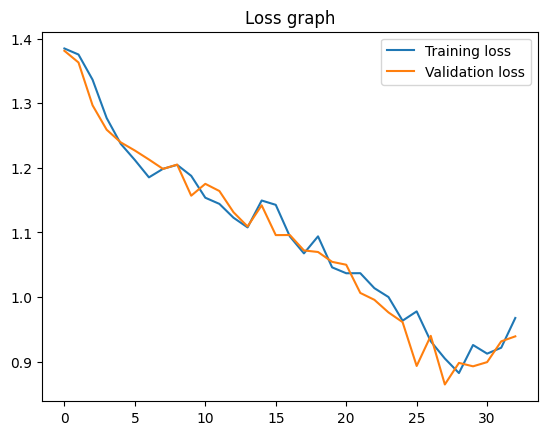

In [43]:
# Plot loss graph
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title("Loss graph")
plt.show()

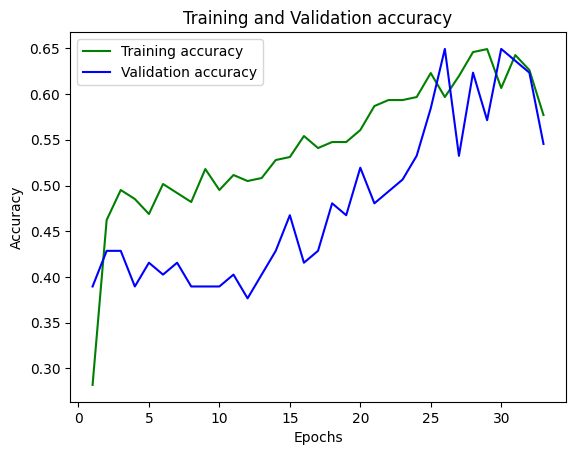

In [44]:
# plot accuracy graph
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
epochs = range(1,len(accuracy_val) + 1)
plt.plot(epochs, accuracy_train, 'g', label='Training accuracy')
plt.plot(epochs, accuracy_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Model's metrics on 20 datasets

In [45]:
from sklearn.metrics import classification_report

In [46]:
shuffled_df = lagged_data.sample(frac=1, random_state=4)

In [47]:
num_datasets = 20
datasets = np.array_split(shuffled_df, num_datasets)

In [48]:
xscaler = MinMaxScaler(feature_range=(0, 1))

In [49]:
saved_model = tf.keras.models.load_model('lstm_magnitude_7_day_lag_3_day_window')

In [50]:
saved_model.summary()

Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_300 (LSTM)             (None, 3, 160)            106240    
                                                                 
 dropout_300 (Dropout)       (None, 3, 160)            0         
                                                                 
 lstm_301 (LSTM)             (None, 3, 160)            205440    
                                                                 
 dropout_301 (Dropout)       (None, 3, 160)            0         
                                                                 
 lstm_302 (LSTM)             (None, 160)               205440    
                                                                 
 dropout_302 (Dropout)       (None, 160)               0         
                                                                 
 dense_100 (Dense)           (None, 4)              

In [51]:
micro_precision_list = []
micro_recall_list = []
micro_f1_list = []

macro_precision_list = []
macro_recall_list = []
macro_f1_list = []

weighted_precision_list = []
weighted_recall_list = []
weighted_f1_list = []

samples_precision_list = []
samples_recall_list = []
samples_f1_list = []

In [52]:
for dataset in datasets:
    X = dataset.iloc[:, :total_features].values
    y = dataset['feature1(t)'].values
    X = xscaler.fit_transform(X)
    X = X.reshape((X.shape[0], n_lag, n_features))
    
    y_pred = saved_model.predict(X)
    y_true = keras.utils.to_categorical(y, 4)
    
    max_indices = np.argmax(y_pred, axis=1)
    one_hot_encoded = np.zeros_like(y_pred)
    one_hot_encoded[np.arange(len(y_pred)), max_indices] = 1
    
    report = classification_report(y_true, one_hot_encoded, output_dict=True, zero_division=0)
    
    micro_precision_list.append(report['micro avg']['precision'])
    micro_recall_list.append(report['micro avg']['recall'])
    micro_f1_list.append(report['micro avg']['f1-score'])
    
    macro_precision_list.append(report['macro avg']['precision'])
    macro_recall_list.append(report['macro avg']['recall'])
    macro_f1_list.append(report['macro avg']['f1-score'])
    
    weighted_precision_list.append(report['weighted avg']['precision'])
    weighted_recall_list.append(report['weighted avg']['recall'])
    weighted_f1_list.append(report['weighted avg']['f1-score'])
    
    samples_precision_list.append(report['samples avg']['precision'])
    samples_recall_list.append(report['samples avg']['recall'])
    samples_f1_list.append(report['samples avg']['f1-score'])

1/1 [==============================] - 0s 23ms/step


In [53]:
avg_micro_precision = np.mean(micro_precision_list)
avg_micro_recall = np.mean(micro_recall_list)
avg_micro_f1 = np.mean(micro_f1_list)

avg_macro_precision = np.mean(macro_precision_list)
avg_macro_recall = np.mean(macro_recall_list)
avg_macro_f1 = np.mean(macro_f1_list)

avg_weighted_precision = np.mean(weighted_precision_list)
avg_weighted_recall = np.mean(weighted_recall_list)
avg_weighted_f1 = np.mean(weighted_f1_list)

avg_samples_precision = np.mean(samples_precision_list)
avg_samples_recall = np.mean(samples_recall_list)
avg_samples_f1 = np.mean(samples_f1_list)

In [54]:
print('Micro')
print(f'Average Micro Precision: {avg_micro_precision}')
print(f'Average Micro Recall: {avg_micro_recall}')
print(f'Average Micro F1-score: {avg_micro_f1}')

print('\n\nMacro')
print(f'Average Macro Precision: {avg_macro_precision}')
print(f'Average Macro Recall: {avg_macro_recall}')
print(f'Average Macro F1-score: {avg_macro_f1}')

print('\n\nWeighted')
print(f'Average Weighted Precision: {avg_weighted_precision}')
print(f'Average Weighted Recall: {avg_weighted_recall}')
print(f'Average Weighted F1-score: {avg_weighted_f1}')

print('\n\nSamples')
print(f'Average Samples Precision: {avg_samples_precision}')
print(f'Average Samples Recall: {avg_samples_recall}')
print(f'Average Samples F1-score: {avg_samples_f1}')

Micro
Average Micro Precision: 0.5968379446640316
Average Micro Recall: 0.5968379446640316
Average Micro F1-score: 0.5968379446640315


Macro
Average Macro Precision: 0.6041904623154624
Average Macro Recall: 0.6170535714285714
Average Macro F1-score: 0.5680086514437537


Weighted
Average Weighted Precision: 0.6255794293541329
Average Weighted Recall: 0.5968379446640316
Average Weighted F1-score: 0.5683296336980516


Samples
Average Samples Precision: 0.5968379446640316
Average Samples Recall: 0.5968379446640316
Average Samples F1-score: 0.5968379446640316


In [55]:
data = {
    'micro_precision': micro_precision_list,
    'micro_recall': micro_recall_list,
    'micro_f1': micro_f1_list,
    'macro_precision': macro_precision_list,
    'macro_recall': macro_recall_list,
    'macro_f1': macro_f1_list,
    'weighted_precision': weighted_precision_list,
    'weighted_recall': weighted_recall_list,
    'weighted_f1': weighted_f1_list,
    'samples_precision': samples_precision_list,
    'samples_recall': samples_recall_list,
    'samples_f1': samples_f1_list,
}

In [56]:
metrics_df = pd.DataFrame(data)

In [57]:
metrics_df

,micro_precision,micro_recall,micro_f1,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1,samples_precision,samples_recall,samples_f1
0,0.695652,0.695652,0.695652,0.564286,0.637500,0.597436,0.606211,0.695652,0.646600,0.695652,0.695652,0.695652
1,0.608696,0.608696,0.608696,0.679167,0.642857,0.605429,0.682609,0.608696,0.586078,0.608696,0.608696,0.608696
2,0.652174,0.652174,0.652174,0.746032,0.656250,0.664916,0.721187,0.652174,0.654914,0.652174,0.652174,0.652174
3,0.608696,0.608696,0.608696,0.631410,0.537500,0.500414,0.692308,0.608696,0.562625,0.608696,0.608696,0.608696
4,0.739130,0.739130,0.739130,0.563194,0.687500,0.612132,0.653140,0.739130,0.688619,0.739130,0.739130,0.739130
5,0.739130,0.739130,0.739130,0.843434,0.696429,0.681349,0.832235,0.739130,0.700690,0.739130,0.739130,0.739130
6,0.652174,0.652174,0.652174,0.726190,0.622619,0.622024,0.689441,0.652174,0.637164,0.652174,0.652174,0.652174
7,0.391304,0.391304,0.391304,0.404167,0.391667,0.382756,0.436232,0.391304,0.400778,0.391304,0.391304,0.391304
8,0.739130,0.739130,0.739130,0.718452,0.729167,0.711310,0.751346,0.739130,0.732402,0.739130,0.739130,0.739130
9,0.565217,0.565217,0.565217,0.525794,0.532738,0.519986,0.543823,0.565217,0.544924,0.565217,0.565217,0.565217


In [58]:
# Get the minimum value of each column
min_values = metrics_df.min()

# Get the maximum value of each column
max_values = metrics_df.max()

print('Minimum Values:')
print(min_values)

print('\n\nMaximum Values:')
print(max_values)

Minimum Values:
micro_precision       0.391304
micro_recall          0.391304
micro_f1              0.391304
macro_precision       0.400298
macro_recall          0.391667
macro_f1              0.382756
weighted_precision    0.419102
weighted_recall       0.391304
weighted_f1           0.363636
samples_precision     0.391304
samples_recall        0.391304
samples_f1            0.391304
dtype: float64


Maximum Values:
micro_precision       0.739130
micro_recall          0.739130
micro_f1              0.739130
macro_precision       0.843434
macro_recall          0.729167
macro_f1              0.711310
weighted_precision    0.832235
weighted_recall       0.739130
weighted_f1           0.732402
samples_precision     0.739130
samples_recall        0.739130
samples_f1            0.739130
dtype: float64


In [59]:
metrics_df.to_csv('metrics/LSTM magnitude 7 day lag 3 day window.csv', index=False)